<H1>Les réseaux de neurones</H1>  

Dans ce notebook nous présentons le fonctionnement des réseaux de neurones. L'objectif pour mieux les comprendre et de bien décomposer les différentes étapes. Pour cela rien de mieux que de programmer "from scratch" une classe réseau de neurones avec des optimisations.

## Installation



Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.


In [ ]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

# sous Colab il faut déjà intégrer ces deux librairies

#!pip install ...


# eventuellement ne pas oublier de relancer le kernel du notebook

In [3]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy

# librairie affichage
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler



# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.utils import np_utils
from keras import regularizers
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0) # pour avoir des figures de même taille

Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [4]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive :

In [5]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024


'/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'

### Les neurones
"Un neurone, ou une cellule nerveuse, est une cellule excitable constituant l'unité fonctionnelle de base du système nerveux. Les neurones assurent la transmission d'un signal bioélectrique appelé influx nerveux. Ils ont deux propriétés physiologiques : l'excitabilité, c'est-à-dire la capacité de répondre aux stimulations et de convertir celles-ci en impulsions nerveuses, et la conductivité, c'est-à-dire la capacité de transmettre les impulsions." (Wikipedia)

La structure d'un neurone (source : https://fr.wikipedia.org/wiki/Fichier:Neurone_-_commenté.svg) :

<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/Neurone.png' width="300" height="250">
</center>
Le fonctionnement est le suivant : tout d'abord, les dendrites reçoivent l’influx nerveux d’autres neurones. Le neurone évalue alors l’ensemble de la stimulation reçue. Si celle-ci est suffisante, il est excité : il transmet un signal (0/1) le long de l ’axone et l’excitation est propagée jusqu’aux autres neurones qui y sont connectés via les synapses.

"Un réseau de neurones artificiels, ou réseau neuronal artificiel, est un système dont la conception est à l'origine schématiquement inspirée du fonctionnement des neurones biologiques" (Wikipedia)  


La structure d'un neurone artificiel :

<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/NeuroneDansUnReseauDeNeurone.png' width="450" height="250">
</center>
Comme nous le constatons, un neurone artificiel est assez similaire à un neurone. Il comprend un ensemble d'entrées (synapses) auxquelles un ensemble de poids sont ajoutés (dans le notebook sur la descente de gradient, ces poids correspondent aux paramètres qu'il fallait trouver pour les fonctions linéaires - $\theta$). Il possède également une entrée particulière appelée *biais*. Une fonction additive (combinaison linéaire)  calcule la somme pondérée des entrées : $\sum_{i}^{} w_ix_i$. La sortie du noeud est déterminée en appliquant une fonction de transfert non-linéaire, $\sigma(\sum_{i}^{} w_ix_i+b)$.  

## Lorsque la régression logistique ne fonctionne plus

Dans le notebook sur la descente de gradient, nous avons terminé par la régression logistique et avons vu qu'il était possible d'afficher les limites de décision (une droite) pour classer les iris. Considérons, à présent, la figure suivante :  

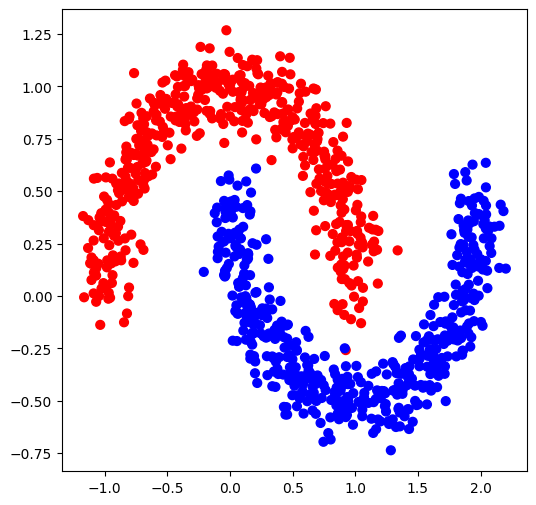

In [6]:
np.random.seed(0)
X, y = make_moons(n_samples=1000, noise=0.1)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm_bright)#cmap=plt.cm.PiYG)

In [7]:
#from :
#https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%201%20-%20Artificial%20Neural%20Networks.ipynb

def plot_decision_boundary(func, X, y):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig, ax = plt.subplots()
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.title("Decision Boundary")

Appliquons, à présent, la logistic regression de sickit learn pour afficher la frontière de decision :

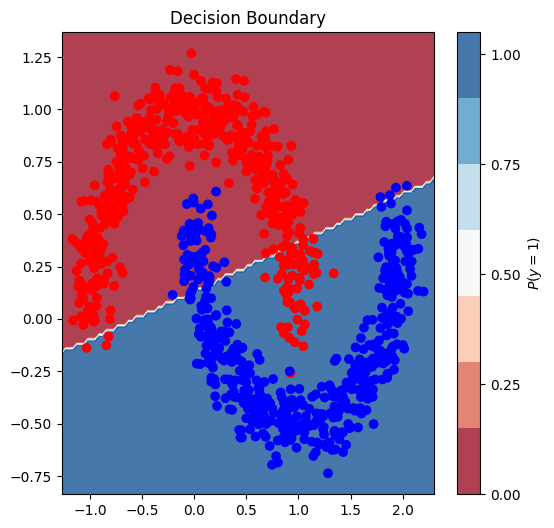

In [8]:
clf = linear_model.LogisticRegression(solver='lbfgs')
clf.fit(X, y)
#Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x),X,y)

Comme nous pouvons le constater les deux ensembles ne peuvent pas être séparés linéairement. Nous avons besoin de quelque chose de plus sophistiqué : les réseaux de neurones.


## Les réseaux de neurones



Les réseaux de neurones se composent des éléments suivants :  

* Une couche d'entrée qui reçoit l'ensemble des caractéristiques (features), i.e. les variables prédictives.

* Un nombre arbitraire de couches cachées.  

* Une couche de sortie, ŷ, qui contient la variable à prédire.  

* Un ensemble de poids W qui vont être ajoutés aux valeurs des features et de biais b entre chaque couche  

* Un choix de fonction d'activation pour chaque couche cachée, σ.

*Remarque* La couche de sortie doit avoir autant de neurones qu'il y a de sorties au problème de classification :
* *régression* : 1 seul neurone (C.f. notebook descente de gradient)
* *classification binaire* : 1 seul neurone avec une fonction d'activation qui sépare les deux classes.
* *classification multi-classe* : 1 neurone par classe et une fonction d'activation Softmax pour avoir la classe appropriée en fonction des probabilités de l'entrée appartenant à chaque classe.

La figure suivante illustre un exemple de réseau avec 3 couches :
* le layer 1 correspond au layer d'entrée (*input layer*), il reçoit l'ensemble des variables prédicives et est composé de 2 neurones. Le neurone avec +1 correspond au biais qui est ajouté.    
* le layer 2 est appelé couche cachée (*hidden layer*), il possède 3 neurones et aussi un biais.
* le layer 3 correspond à la couche de sortie (*output layer*), la sortie de ce layer correspond à la prédiction.  


<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/unreseaudeep3.png' width="550" height="300">
</center>

La figure suivante illustre le même réseau avec les poids affectés.

<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/unreseaudeeppoids6.png' width="550" height="300">
</center>

**Notations** : $X$ correspond aux variables prédictives. Le poids est identifié de la manière suivante : $w_{ij}^{[l]}$ où $l$ correspond au niveau du layer cible, $i$ correspond au numéro du nœud de la connection dans la couche $l-1$ et $j$ correspond au numéro du nœud de la connection dans la couche $l$. Par exemple, le poids entre le nœud 1 dans le layer 1 et le nœud 2 dans le layer 2 est noté : $w_{12}^{[2]}$. Un biais est connecté à chaque nœud de la couche suivante. La notation est similaire : $b_i^{[l]}$ où $i$ est le numéro du nœud de la couche supérieure. La sortie d'un nœud est notée = $a_i^{[l]}$ où $i$ correspond au numéro du nœud dans la couche $l$. **ŷ** correspond à la variable prédite.




**Choix de la fonction d'activation**

<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/Activations.png' width="600" height="270">
</center>

Il existe de très nombreuses fonctions d'activation qui peuvent être utilisées :
* Binary Step  
*  Sigmoid  
*  Tanh  
*  ReLU  
* Leaky ReLU  
* Softmax  
* ...  


Elles n'ont pas les mêmes propriétés.   

Nous verrons, par la suite, que les réseaux de neurones utilisent la descente de gradient, le comportement de la dérivée des fonctions est donc important. Par exemple, nous avons vu que la sigmoid va transformer de grandes valeurs d'entrée dans des valeurs comprises entre 0 et 1. Cela veut dire qu'une modification importante de l'entrée entraînera une modification mineure de la sortie (C.f. notebook descente de gradient). Par conséquent la dérivée devient plus petite comme l'illustre l'image ci-dessous :   

<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/sigmoid_derivative.png' width="400">  
</center>
En fait, pour corriger les erreurs, les dérivées du réseau vont être propagées layer par layer de l'output layer à l'input layer. Le problème est que celles-ci sont multipliées entre chaque layer afin de connaître les valeurs de dérivées utiles pour l'input layer : le gradient décroît de façon exponentielle à mesure que nous nous propagons jusqu'aux couches initiales.


Pour choisir les fonctions d'activation, il faut considérer les propriétés principales suivantes :  

* La disparition du gradient (*vanishing gradient*) : le problème intervient généralement dans des réseaux avec de très nombreux layer. Comme les descentes de gradient sont propagées dans tout le réseau, de trop petites valeurs de gradient (le gradient de la fonction de perte approche 0) indiquent que les poids des premiers layers ne seront pas mis à jour efficacement à chaque étape. Ceci entraîne donc une imprécision globale du réseau. Cela peut arriver si le réseau est composé de nombreuses couches avec une sigmoid.
* Disparition de neurones (*dead neuron*) : un neurone mort est un neurone qui, lors de l'apprentissage, ne s'active plus. Cela est lié au fait que les dérivées sont très petites ou nulles. Le neurone ne peut donc pas mettre à jour les poids. Les erreurs ne se propageant plus, ce neurone peut affecter les autres neurones du réseau. C'est, par exemple, le cas avec ReLu qui renvoie 0 quand l'entrée est inférieure ou égale à 0. Si chaque exemple donne une valeur négative, le neurone ne s'active pas et après la descente de gradient le neurone devient 0 donc ne sera plus utilisé. Le Leaky Relu permet de résoudre ce problème.  
* Explosion du gradient (*Explosing gradient*) : le problème se pose lorsque des gradients d'erreur important s'accumulent et entraînent des mises à jour importantes des poids. Cela amène un réseau instable : les valeurs de mises à jour des poids peuvent être trop grandes et être remplacées par des NaN donc non utilisables (s'il n'y a pas d'erreurs d'exécution bien sûr !). Le problème est lié au type de descente de gradient utilisé (Batch vs mini-batch), au fait qu'il y a peut être trop de couches dans le réseau et bien sûr à certaines fonctions d'activation qui favorisent ce problème.  
* Saturation de neurones (*Saturated neurons*) : le problème est lié au fait que les valeurs grandes (resp. petites) atteignent un plafond et qu'elles ne changent pas lors de la propagation dans le réseau. Ce problème est principalement lié aux fonctions sigmoid et tanh. En effet, sigmoid, pour toutes les valeurs supérieures à 1 va arriver sur un plateau et retournera toujours 1. Pour cela, ces deux fonctions d'activations sont assez déconseillées en deep learning (préférer LeRu ou Leaky Relu).  



Pour avoir une idée du comportement des différentes fonctions d'activation et de leurs conséquences :
’’


Une fois que tout est fixe, le réseau de neurones s'exécute alors en deux étapes :
* Forward Propagation
* Backward Propagation  





### Forward Propagation

L'objectif de cette étape est de déterminer la valeur de sortie du réseau : **ŷ**.


Comme nous avons vu dans le notebook descente de gradient, pour chaque neurone de la couche, nous effectuons une application affine en considérant les valeurs issues de la couche précédente (i.e. $a$ représente le résultat de la fonction d'activation de la couche précédente) :  


$$\mathbf{z}_i^{[l]}=\mathbf{w}^T_i \bullet \mathbf{a}^{[l-1]}+b_i\ \ \ \ \ \  \mathbf{a}_i^{[l]}=\sigma^{[l]}(\mathbf{z}_i^{[l]})$$

Que nous pouvons donc généraliser en utilisant les matrices :  

$$\begin{array}{l}
\mathbf{Z}^{[l]} = \mathbf{W}^{[l]} \bullet \mathbf{A}^{[l-1]} + \mathbf{b}^{[l]}\\  
\mathbf{A}^{[l]}=\sigma^{[l]}(\mathbf{Z}^{[l]})\\
\end{array}
$$  

Si nous reprenons l'exemple de réseau précédent avec ReLu pour le hidden layer et sigmoid pour le layer de sortie nous avons donc :   

$$\begin{array}{l}
\mathbf{A}^{[0]}=X\\
\end{array}
$$  

où $\mathbf{A}^{[0]}=X$ la matrice contenant les exemples d'apprentissage.  

$$\begin{array}{l}
\mathbf{Z}^{[1]} = \mathbf{W}^{[1]} \bullet \mathbf{A}^{[0]} + \mathbf{b}^{[1]}\\
\mathbf{A}^{[1]}=ReLu^{[1]}(\mathbf{Z}^{[1]})\\
\mathbf{Z}^{[2]} = \mathbf{W}^{[2]} \bullet \mathbf{A}^{[1]} + \mathbf{b}^{[2]}\\
\mathbf{A}^{[2]}=Sigmoid^{[2]}(\mathbf{Z}^{[2]})\\  
\end{array}
$$

Finalement : $ŷ=\mathbf{A}^{[2]}$



Le code ci-dessous illustre un exemple simple de la phase forward propagation pour notre exemple comportant deux variables prédictives. Les fonctions d'activations sont respectivement Relu pour le hidden layer et  sigmoid pour le dernier layer.

In [9]:
#fonctions d'activation
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def valueoutput(y_hat):
    for i in range(len(y_hat)):
        if y_hat[i]>0.5:
            y_hat[i]=1
        else:
            y_hat[i]=0
    return y_hat

# les donnees d'entree sous la forme d'une matrice (array en python)
X = np.array(([0, 1],
               [0, 0],
               [1, 0],
               [1, 1],
               [1, 1]))
# les donnees de sortie sous la forme d'un vecteur
y = np.array(([1],
              [0],
              [0],
              [1],
              [1]), dtype=float)


# initialisation des poids de manière aléatoire ainsi que des biais
inputSize = 2
hiddenSize = 3
outputSize = 1
W1=np.random.rand(2, 3)
W2=np.random.rand(3, 1)
b1 = np.random.rand(3)
b2 = np.random.rand(1)
print ("Les données d'entrées : \n",X)
print ('Les valeurs de poids et de biais initialisees aléatoirement : \n')
print ('\t(layer input vers layer 1) : W1 \n',W1,'\n')
print ('\t(layer input vers layer 1) : b1\n',b1,'\n')
print ("\t(layer 1 vers layer 2) : W2\n",W2,'\n')
print ("\t(layer 1 vers layer 2) : b2\n",b2,'\n')
print ("Etape 1 : ")
print ("\n A0=X\n")

A0=X
Z1 = np.dot(A0,W1)+b1
print ("\n Z1 = W1.A0 + b1  \n",Z1,'\n')
A1 = relu(Z1)
print ('\nA1 = relu(Z1)\n',A1,'\n')
Z2 = np.dot(A1,W2)+b2
print ("\n Z2 = W2.A1 + b2  \n",Z2,'\n')
A2 = sigmoid(Z2)
print ('\nA2 = sigmoid(Z2)\n',A2,'\n')
y_hat = sigmoid(Z2)
print ('yhat\n',y_hat)



print ("Les données d'entrées : \n",X)
print ("Les sorties predites : \n", str(valueoutput(y_hat)))

print ("Les sorties reelles attendues : \n", str(y))

Les données d'entrées : 
 [[0 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]]
Les valeurs de poids et de biais initialisees aléatoirement : 

	(layer input vers layer 1) : W1 
 [[0.90496764 0.66934312 0.61669425]
 [0.70675322 0.21538845 0.58636595]] 

	(layer input vers layer 1) : b1
 [0.55441685 0.50237972 0.86147085] 

	(layer 1 vers layer 2) : W2
 [[0.68936531]
 [0.25632519]
 [0.84027211]] 

	(layer 1 vers layer 2) : b2
 [0.18734206] 

Etape 1 : 

 A0=X


 Z1 = W1.A0 + b1  
 [[1.26117007 0.71776817 1.4478368 ]
 [0.55441685 0.50237972 0.86147085]
 [1.45938449 1.17172285 1.4781651 ]
 [2.16613771 1.38711129 2.06453105]
 [2.16613771 1.38711129 2.06453105]] 


A1 = relu(Z1)
 [[1.26117007 0.71776817 1.4478368 ]
 [0.55441685 0.50237972 0.86147085]
 [1.45938449 1.17172285 1.4781651 ]
 [2.16613771 1.38711129 2.06453105]
 [2.16613771 1.38711129 2.06453105]] 


 Z2 = W2.A1 + b2  
 [[2.45730789]
 [1.4221803 ]
 [2.73579409]
 [3.77092168]
 [3.77092168]] 


A2 = sigmoid(Z2)
 [[0.92109422]
 [0.80567999]
 [0.939106

Comme nous pouvons le constater il y a des erreurs dans les sorties prédites. C'est là qu'intervient la seconde phase.

### Backward Propagation

L'objectif de la Backward Propagation est tout d'abord d'évaluer la différence entre la valeur prédite et la valeur réelle.   

*Etape 1 : (calcul du coût)*

Nous avons vu dans le notebook de la descente de gradient que la différence entre la valeur obtenue dans l'étape précédente et la valeur réelle correspond au coût. Plus la différence est élevée, plus le coût sera élevé. Pour minimiser ce coût, il faut trouver les valeurs de poids et de biais pour lesquelles la fonction de coût renvoie la plus petite valeur possible. Plus le coût est faible, plus les prévisions sont exactes. Nous retrouvons donc le problème rencontré pour la descente de gradient.

Précédemment nous avons vu que la cross entropy, comme fonction de coût, était bien adaptée à notre problème de classification binaire, donc :  

$$\mathbf{C(ŷ,y)=-ylog(ŷ)-(1-y)log(1-ŷ)}$$

L'objectif, à présent, est de propager cette erreur dans tout le réseau pour mettre à jour les différents poids.


*Etape 2 : (backpropagation)*  
**Comprendre ce qui est derrière**  

Nous avons vu précédemment, lors de la phase de forward, que l'exécution était de la forme :  

$$\begin{array}{l}
\mathbf{A}^{[0]}=X\\
\mathbf{Z}^{[1]} = \mathbf{W}^{[1]} \bullet \mathbf{A}^{[0]} + \mathbf{b}^{[1]}\\
\mathbf{A}^{[1]}=\sigma^{[1]}(\mathbf{Z}^{[1]})\\
\mathbf{Z}^{[2]} = \mathbf{W}^{[2]} \bullet \mathbf{A}^{[1]} + \mathbf{b}^{[2]}\\
\mathbf{A}^{[2]}=\sigma^{[2]}(\mathbf{Z}^{[2]})\\
\vdots \\
\mathbf{Z}^{[L]} = \mathbf{W}^{[L]}\bullet \mathbf{A}^{[L-1]} + \mathbf{b}^{[L]}\\
\mathbf{A}^{[L]}=\sigma^{[L]}(\mathbf{Z}^{[L]})=ŷ\\
\end{array}$$  

où $L$ est le output layer.  

La figure suivante illustre les étapes jusqu'à la fonction de coût pour notre réseau exemple :  

<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/ForwardVertical2.png' width="400" height="270">
</center>

L'objectif de la backward propagation est de reporter, dans le réseau, l'ensemble des modifications à apporter aux poids entre les couches. Pour cela il faut repartir en sens inverse pour calculer les dérivées partielles du coût. Elle repose sur la règle de dérivation en chaîne (*chain rule*) qui est une formule qui explicite la dérivée d'une fonction composée pour deux fonctions dérivables :  

$$\mathbf{\frac{dy}{dx}=\frac{dy}{du}\frac{du}{dx}}$$  

Lorsque l'on regarde la fin du réseau, nous constatons que $\mathbf{C}$ est une fonction qui dépend de $\mathbf{A^{[2]}}$, que $\mathbf{A^{[2]}}$ dépend, elle même, d'une fonction $\mathbf{Z^{[2]}}$ et que finalement $\mathbf{Z^{[2]}}$ dépend de $\mathbf{W^{[2]}}$ et de  $\mathbf{b^{[2]}}$.

$$\mathbf{\frac{\partial C}{\partial W^{[2]}}}=\mathbf{\frac{\partial C}{\partial A^{[2]}}}\bullet \mathbf{\frac{\partial A^{[2]}}{\partial Z^{[2]}}}\bullet\mathbf{\frac{\partial Z^{[2]}}{\partial W^{[2]}}}$$  

$$\mathbf{\frac{\partial C}{\partial b^{[2]}}}=\mathbf{\frac{\partial C}{\partial A^{[2]}}}\bullet \mathbf{\frac{\partial A^{[2]}}{\partial Z^{[2]}}}\bullet\mathbf{\frac{\partial Z^{[2]}}{\partial b^{[2]}}}$$  



De la même manière, pour avoir la dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{W^{[1]}}$ et   $\mathbf{b^{[1]}}$, nous voyons, sur la figure, que $\mathbf{Z^{[2]}}$ est une fonction qui dépend de $\mathbf{A^{[1]}}$, qui, elle-même, dépend de $\mathbf{Z^{[1]}}$ et que finalement $\mathbf{Z^{[1]}}$ dépend de $\mathbf{W^{[1]}}$ et $\mathbf{b^{[1]}}$.  

$$\mathbf{\frac{\partial C}{\partial W^{[1]}}}=\mathbf{\frac{\partial C}{\partial A^{[2]}}}\bullet \mathbf{\frac{\partial A^{[2]}}{\partial Z^{[2]}}}\bullet\mathbf{\frac{\partial Z^{[2]}}{\partial A^{[1]}}}\bullet\mathbf{\frac{\partial A^{[1]}}{\partial Z^{[1]}}}\bullet\mathbf{\frac{\partial Z^{[1]}}{\partial W^{[1]}}}$$


$$\mathbf{\frac{\partial C}{\partial b^{[1]}}}=\mathbf{\frac{\partial C}{\partial A^{[2]}}}\bullet \mathbf{\frac{\partial A^{[2]}}{\partial Z^{[2]}}}\bullet\mathbf{\frac{\partial Z^{[2]}}{\partial A^{[1]}}}\bullet\mathbf{\frac{\partial A^{[1]}}{\partial Z^{[1]}}}\bullet\mathbf{\frac{\partial Z^{[1]}}{\partial b^{[1]}}}$$  

Les différentes étapes sont résumées sur la figure suivante :  
<center>
<img src='https://www.lirmm.fr/~poncelet/Ressources/BackwardVertical2.png' width="400" height="270">  
</center>
Pour résumer, les équations pour calculer la dérivée partielle de la fonction de coût en fonction des poids et des biais d'une couche  $\mathbf{l}$ sont :

$$\mathbf{\frac{\partial C}{\partial W^{[l]}}}=\mathbf{\frac{\partial C}{\partial Z^{[l]}}}\bullet \mathbf{\frac{\partial Z^{[l]}}{\partial W^{[l]}}}$$

$$\mathbf{\frac{\partial C}{\partial b^{[l]}}}=\mathbf{\frac{\partial C}{\partial Z^{[l]}}}\bullet \mathbf{\frac{\partial Z^{[l]}}{\partial b^{[l]}}}$$  

Donc, pour obtenir les dérivées partielles de $\mathbf{C}$ par rapport à $\mathbf{W^{[l]}}$ et
$\mathbf{b^{[l]}}$, nous devons calculer :  

$$\mathbf{\frac{\partial C}{\partial A^{[L]}},\frac{\partial C}{\partial Z^{[L]}},\frac{\partial C}{\partial Z^{[l]}}\frac{\partial Z^{[l]}}{\partial W^{[l]}},\frac{\partial Z^{[l]}}{\partial b^{[l]}}}$$  


Par la suite, et par simplification, nous considérons que les deux fonctions d'activation dans notre réseau sont Relu (pour $A^{[1]}$) et sigmoid (pour $A^{[2]}$). Le principe est le même quelques soient les fonctions, il suffit juste de connaître la dérivée des fonctions d'activation.    



**Pour la dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{A^{[L]}}$ :**  

$$\mathbf{\frac{\partial C}{\partial A^{[L]}}}=
\mathbf{\frac{\partial (-ylog(A^{[L]})-(1-y)log(1-A^{[L]}))}{\partial A^{[L]}}}$$

Nous savons que la dérivée d'une fonction log(x) est :
$$\mathbf{\frac{\partial log(x)}{\partial dx}}=\mathbf{\frac{1}{x}}$$  

Pour la partie gauche $\mathbf{-ylog(A^{[L]})}$ nous avons donc comme dérivée :  
$$\mathbf{\frac{-y}{A^{[L]}}}$$


Pour la partie droite $\mathbf{-(1-y)log(1-A^{[L]})}$, il faut juste appliquer la formule de la dérivée d'une fonction  :

$$\mathbf{\frac{\partial log(g(x))}{\partial dx}}=\mathbf{\frac{1}{g(x)}g'(x))}$$  
comme la dérivée de $\mathbf{1-A^{[L]}}$ est $\mathbf{-1}$ nous avons au final :

$$\mathbf{\frac{\partial C}{\partial A^{[L]}}}=\mathbf{\frac{-y}{A^{[L]}}}-(-)\mathbf{\frac{(1-y)}{(1-A^{[L]})}}$$  


$$=\mathbf{\left(\frac{-y}{A^{[L]}}+\frac{(1-y)}{(1-A^{[L]})}\right)}$$  

Donc :   


$$\begin{array}{|c|}
\hline
\mathbf{\frac{\partial C}{\partial A^{[L]}}} = \mathbf{\left(\frac{-y}{A^{[L]}}+\frac{(1-y)}{(1-A^{[L]}})\right)}\\
\hline
\end{array}$$  

**Considérons, à présent la dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{Z^{[L]}}$ : **

$$\mathbf{\frac{\partial C}{\partial Z^{[L]}}}$$  

En utilisant la chaîne de dérivation :  

$$\mathbf{\frac{\partial C}{\partial Z^{[L]}}}=\mathbf{\frac{\partial C}{\partial A^{[L]}}}\bullet \mathbf{\frac{\partial A^{[L]}}{\partial Z^{[L]}}}=\mathbf{\frac{\partial C}{\partial A^{[L]}}*\sigma'^{[L]}(Z^{[L]})}$$

$\mathbf{\sigma'^{[L]}(Z^{[L]})}$ correspond simplement à la dérivée de la sigmoid. Nous avons vu dans le notebook sur la descente de gradient, que cette dérivée est :   

$$\mathbf{\frac{\partial A^{[L]}}{\partial Z^{[L]}}}=\mathbf{sigmoid(Z^{[L]})(1-sigmoid(Z^{[L]}))}=\mathbf{A^{[L]}(1-A^{[L]})}$$

Donc :  


$$\mathbf{\frac{\partial C}{\partial A^{[L]}}}\bullet \mathbf{\frac{\partial A^{[L]}}{\partial Z^{[L]}}}=\mathbf{\left(\frac{-y}{A^{[L]}}+\frac{(1-y)}{(1-A^{[L]})}\right)}\mathbf{A^{[L]}(1-A^{[L]})}$$  

Nous pouvons multiplier par $\mathbf{(1-A^{[L]})}$ et $\mathbf{(A^{[L]})}$ pour simplifier :
$$=\mathbf{\left(\frac{-y(1-A^{[L]})}{A^{[L]}(1-A^{[L]})}+\frac{A^{[L]}(1-y)}{A^{[L]}(1-A^{[L]})}\right)}\mathbf{A^{[L]}(1-A^{[L]})}$$  

$$=\mathbf{\left(\frac{-y(1-A^{[L]})+A^{[L]}(1-y)}{A^{[L]}(1-A^{[L]})}\right)}\mathbf{A^{[L]}(1-A^{[L]})}$$


en supprimant $\mathbf{A^{[L]}(1-A^{[L]})}$ nous avons :  
$$=\mathbf{\left(-y(1-A^{[L]})+A^{[L]}(1-y)\right)}$$

$$=\mathbf{-y+yA^{[L]}+A^{[L]}-A^{[L]}y}$$  

$$=\mathbf{-y+A^{[L]}}$$  

Donc :

$$\begin{array}{|c|}
\hline
\mathbf{\frac{\partial C}{\partial Z^{[L]}}}=\mathbf{A^{[L]}-y}\\
\hline
\end{array}$$

**Dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{Z^{[l]}}$ :**  
Nous souhaitons, à présent, obtenir la dérivée partielle de $\mathbf{C}$ par rapport à un niveau $\mathbf{l}$, i.e. $\mathbf{Z^{[l]}}$. Le principe étant que si l'on connaît $\mathbf{Z^{[L]}}$, il est possible de déduire $\mathbf{Z^{[L-1]}}$, $\mathbf{Z^{[L-2]}}$, ...  

Nous savons, en appliquant la chaîne de dérivation, qu'il est possible de calculer la dérivée de $\mathbf{\frac{\partial C}{\partial Z^{[l]}}}$ par :  

$$\mathbf{\frac{\partial C}{\partial Z^{[l]}}=\frac{\partial C}{\partial Z^{[l+1]}}\bullet\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}\bullet\frac{\partial A^{[l]}}{\partial Z^{[l]}} }$$

Comme :
$$\mathbf{Z^{[l+1]}=W^{[l+1]}\bullet A{[l]}+b{[l+1]}}$$

$$\mathbf{\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}= \frac{\partial (W^{[l+1]}\bullet A{[l]}+b{[l+1]})}{\partial A^{[l]}}}$$  

$$\mathbf{=W^{[l+1]}}$$

Nous avons également :

$$\mathbf{\frac{\partial A^{[l]}}{\partial Z^{[l]}}= \sigma'^{[l]}(Z^{[l]})}$$

Donc :  

$$\begin{array}{|c|}
\hline
\mathbf{\frac{\partial C}{\partial Z^{[l]}} =(W^{[l+1]^T} \bullet \frac{\partial C}{\partial Z^{[l+1]}})*\sigma'^{[l]}(Z^{[l]})}\\
\hline
\end{array}$$

*Dérivée partielle de $\mathbf{Z^{[l]}}$ par rapport à $\mathbf{W^{[l]}}$ :*  

Dans un premier temps nous calculons la dérivée partielle de $\mathbf{Z^{[l]}}$ par rapport à $\mathbf{W^{[l]}}$ pour, par la suite déterminer la dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{W^{[l]}}$.  

Comme :
$$\mathbf{Z^{[l]}=W^{[l]}\bullet A{[l-1]}+b{[l]}}$$

$$\mathbf{\frac{\partial Z^{[l]}}{\partial W^{[l]}} =\frac{\partial (W^{[l]}\bullet A{[l-1]}+b{[l]})}{\partial W^{[l]}}}$$

$$\mathbf{= A^{[l-1]}}$$

**Dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{W^{[l]}}$ :**  

A partir du résultat précédent, nous avons :

$$\begin{array}{|c|}
\hline
\mathbf{\frac{\partial C}{\partial W^{[l]}} =\frac{\partial C}{\partial Z^{[l]}}\bullet A^{[l-1]^T}}\\
\hline
\end{array}$$

*Dérivée partielle de $\mathbf{Z^{[l]}}$ par rapport à $\mathbf{b^{[l]}}$ :*  

Comme précédemment, nous calculons la dérivée partielle de $\mathbf{Z^{[l]}}$ par rapport à $\mathbf{b^{[l]}}$ pour, par la suite déterminer la dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{b^{[l]}}$.

Comme :
$$\mathbf{Z^{[l]}=W^{[l]}\bullet A{[l-1]}+b{[l]}}$$

$$\mathbf{\frac{\partial Z^{[l]}}{\partial b^{[l]}} =\frac{\partial (W^{[l]}\bullet A{[l-1]}+b{[l]})}{\partial b^{[l]}}}$$

$$\mathbf{= 1}$$  

**Dérivée partielle de $\mathbf{C}$ par rapport à $\mathbf{b^{[l]}}$ :**  

A partir du résultat précédent, nous avons :  


$$\begin{array}{|c|}
\hline
\mathbf{\frac{\partial C}{\partial b^{[l]}} =\frac{\partial C}{\partial Z^{[l]}}}\\
\hline
\end{array}$$


**Pour résumer**

A présent, pour le dernier layer $\mathbf{L}$, nous sommes capable de calculer la dérivée partielle du coût par rapport à $\mathbf{A^{[L]}}$, $\mathbf{Z^{[L]}}$, $\mathbf{W^{[L]}}$ et $\mathbf{b^{[L]}}$ :

$$\begin{array}{|c|c|}
\hline
\mathbf{\frac{\partial C}{\partial A^{[L]}}} & \mathbf{\left(\frac{-y}{A^{[L]}}+\frac{(1-y)}{(1-A^{[L]})}\right)}\\
\hline
\mathbf{\frac{\partial C}{\partial Z^{[L]}}} & \mathbf{(A^{[L]}-y)}\\
\hline
\mathbf{\frac{\partial C}{\partial W^{[L]}}} & \mathbf{\frac{\partial C}{\partial Z^{[L]}}\bullet (A^{[L-1]^T})}\\
\hline
\mathbf{\frac{\partial C}{\partial b^{[L]}}} & \mathbf{\frac{\partial C}{\partial Z^{[L]}}}\\
\hline
\end{array}$$

Pour n'importe quel layer $\mathbf{l}$, nous avons :
$$\begin{array}{|c|c|}
\hline
\mathbf{\frac{\partial C}{\partial Z^{[l]}}} & \mathbf{(W^{[l+1]^T} \bullet \frac{\partial C}{\partial Z^{[l+1]}})*\sigma'^{[l]}(Z^{[l]})}\\
\hline
\mathbf{\frac{\partial C}{\partial W^{[l]}}} & \mathbf{\frac{\partial C}{\partial Z^{[l]}}\bullet A^{[l-1]^T}}\\
\hline
\mathbf{\frac{\partial C}{\partial b^{[l]}}} & \mathbf{\frac{\partial C}{\partial Z^{[l]}}}\\
\hline
\end{array}$$

**La descente de gradient**  

Attention, parfois, la backward propagation est considérée comme la descente de gradient. Ce n'est pas le cas. Elle a pour seul objectif de calculer les gradients pour les opérations à chaque niveau. La descente de gradient intervient après, elle permet de pouvoir mettre automatiquement les poids des différents layer en appliquant justement les gradients obtenus dans l'étape précédente.


La descente de gradient se fait comme dans le notebook : il faut boucler jusqu'au premier layer pour appliquer la formule du gradient à l'aide des dérivées calculées précédemment :  


**For $\mathbf{l}$ in enumate (dernier_layer,1) {**
$$\mathbf{W^{[l]}=W^{[l]}-\eta \frac{\partial C}{\partial W^{[l]}}}$$
$$\mathbf{b^{[l]}=b^{[l]}-\eta \frac{\partial C}{\partial b^{[l]}}}$$
**}**  

Remarque : comme nous l'avons vu lors des dérivations, il est nécessaire de sauvegarder $\mathbf{\frac{\partial C}{\partial W^{[l]}}}$ et $\mathbf{\frac{\partial C}{\partial b^{[l]}}}$ pour pouvoir les réutiliser lors de la descente de gradient.



### Cas de la classification multi-classes

Jusqu'à présent nous avons vu comment faire de la classification binaire, i.e. la fonction d'activation est une sigmoid. Pour faire de la classification multi-classe, il faut utiliser la fonction d'activation softmax. Elle attribue des probabilités à chaque classe d'un problème à plusieurs classes et la somme de ces probabilités doit être égale à 1. Formellement softmax, prend en entrée un vecteur de C-dimensions (le nombre de classes possibles) $\mathbf{z}$ et retourne un autre vecteur de C-dimensions $\mathbf{a}$ de valeurs réelles comprises entre 0 et 1.

Pour $i=1 \cdots C$ :
$$\mathbf{a_i=\frac{e^{z_i}}{\sum_{k=1}^{C}e^{z_k}}}$$
$$ avec\ \sum_{i=1}^{C}=1$$

où $C$ correspond au nombre de classes.  


In [10]:
def softmax(z):
    expz = np.exp(z)
    return expz / expz.sum(axis=0, keepdims=True)

nums = np.array([4, 5, 6])
print(softmax(nums))
print ("la somme des probabilités donne 1")

[0.09003057 0.24472847 0.66524096]
la somme des probabilités donne 1


Cependant, cette fonction n'est pas très stable : elle génère souvent des nan pour des grands nombres par exemple.

In [11]:
nums = np.array([4000, 5000, 6000])
print(softmax(nums))

[nan nan nan]


<ipython-input-10-e3992a5f37a2>:2: RuntimeWarning: overflow encountered in exp
  expz = np.exp(z)
<ipython-input-10-e3992a5f37a2>:3: RuntimeWarning: invalid value encountered in divide
  return expz / expz.sum(axis=0, keepdims=True)


Aussi il est fréquent de multiplier le numérateur par une constante : généralement $-max(z)$ :  

$$\mathbf{a_i=\frac{e^{z_i-max(z)}}{\sum_{k=1}^{C}e^{z_k-max(z)}}}$$

In [12]:
def softmax(z):
    expz = np.exp(z - np.max(z))
    return expz / expz.sum(axis=0, keepdims=True)

nums = np.array([4, 5, 6])
print(softmax(nums))
print ("la somme des probabilités donne 1")
nums = np.array([4000, 5000, 6000])
print(softmax(nums))

[0.09003057 0.24472847 0.66524096]
la somme des probabilités donne 1
[0. 0. 1.]


**Dérivée de la fonction softmax**

Elle est basée sur le fait de considérer la ré-écriture suivante :  

$$\mathbf{g(x)=e^{z_i}}$$
et
$$\mathbf{h(x)=\sum_{k=1}^{C}e^{z_k}}$$

Nous savons que la dérivée d'une fonction $\mathbf{f(x)=\frac{g(x)}{h(x)}}$ est :  

$$\mathbf{f'(x)=\frac{g'(x)h(x)-h'(x)g(x)}{h(x)^2}}$$

Par simplification, nous notons :
$$\mathbf{\sum_C=\sum_{k=1}^{C}e^{z_k}}$$

Pour $i=1 \cdots C$, nous avons :

$$\mathbf{a_i=\frac{e^{z_i}}{\sum_{C}}}$$

La dérivée $\mathbf{\frac{\partial a_i}{\partial z_j}}$ de la sortie de softmax $\mathbf{a}$ par rapport à $\mathbf{z}$ :

* Si $\mathbf{i=j}$,
$$\mathbf{\frac{\partial a_i}{\partial z_i}=\frac{\partial (\frac{e^{z_i}}{\sum_{C}})}{\partial z_i}
=\frac{e^{z_i}\sum_{C}-e^{z_i}e^{z_i}}{\sum_{C}^2}=\frac{e^{z_i}}{\sum_{C}}\frac{\sum_{C}-e^{z_i}}{\sum_{C}}=
\frac{e^{z_i}}{\sum_{C}}(1-\frac{e^{z_i}}{\sum_{C}})=a_i(1-a_i)}$$
Remarque : il s'agit du même résultat que pour la dérivée de la sigmoid.  

* Si $\mathbf{i \ne j}$,
$$\mathbf{\frac{\partial a_i}{\partial z_j}=\frac{\partial (\frac{e^{z_i}}{\sum_{C}})}{\partial z_j}
=\frac{0-e^{z_i}e^{z_j}}{\sum_{C}^2}=\frac{e^{z_i}}{\sum_{C}}\frac{e^{z_j}}{\sum_{C}}=-a_ia_j}$$  

**Dérivée par rapport à la fonction de coût**  

En appliquant le même principe que précédemment, on trouve :

$$\mathbf{\frac{\partial C}{\partial Z^{[L]}}}=\mathbf{A^{[L]}-y}$$

Donc toutes les dérivées précédentes pour $\mathbf{W}$ et $\mathbf{b}$ sont également similaires.

Il est par contre nécessaire de redéfinir la fonction de prédiction. Généralement lorsqu'il y a plusieurs classes, il convient de transformer le $\mathbf{y}$ initial en utilisant la fonction *OneHotEncoder*. Parfois, au préalable, il est indispensable de transformer les labels s'il s'agit d'attributs catégoriels en nombre via *LabelEncoder*. (Cf. notebook ingénierie des données).

In [13]:
# Transformation du label
labelencoder = LabelEncoder()
exemple=np.array(["positif","negatif","positif","negatif"])
print ("Exemple ",exemple)
label_encoded=labelencoder.fit_transform(exemple)
print ("labels encodés :",label_encoded)


# Encodage via OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
#il est indispensable de faire un reshape

integer_encoded = label_encoded.reshape(len(label_encoded), 1)
final = onehot_encoder.fit_transform(integer_encoded)
print ("Encodage final :\n", final)

Exemple  ['positif' 'negatif' 'positif' 'negatif']
labels encodés : [1 0 1 0]
Encodage final :
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


Dans le cas de la prédiction, l'objectif est de retourner la classe qui a la plus forte probabilité à la sortie de softmax. Pour cela nous pouvons utiliser la fonction *argmax*.

In [14]:
exemple = np.array ([[0,2,25,4],
                    [1,11,8,10],
                    [200,7,5,10]])
print (exemple)


[[  0   2  25   4]
 [  1  11   8  10]
 [200   7   5  10]]


In [15]:
print ("\nPosition du plus grand élément : ",np.argmax(exemple))
print ("200 est le 8 ième élement (on compte à partir de 0)\n")

print ("Axis = 0 : la fonction cherche la valeur maximale sur les colonne de la matrice")
print("\nIndice de l'élément max en considérant les colonnes : ", np.argmax(exemple, axis = 0))
print ("colonne 0 : 200 est le plus grand de la colonne (retourne ligne 2)")
print ("colonne 1 : 11 est le plus grand de la colonne (retourne ligne 1)")
print ("colonne 2 : 25 est le plus grand de la colonne (retourne ligne 0)")
print ("colonne 3 : 10 est le plus grand de la colonne (retourne ligne 1)\n")

print ("Axis = 1 : la fonction cherche la valeur maximale sur les lignes de la matrice")
print("\nIndices of Max element : ", np.argmax(exemple, axis = 1))
print ("ligne 0 : 25 est le plus grand de la colonne (retourne colonne 2)")
print ("ligne 1 : 11 est le plus grand de la colonne (retourne colonne 1)")
print ("ligne 2 : 200 est le plus grand de la colonne (retourne colonne 0)")


Position du plus grand élément :  8
200 est le 8 ième élement (on compte à partir de 0)

Axis = 0 : la fonction cherche la valeur maximale sur les colonne de la matrice

Indice de l'élément max en considérant les colonnes :  [2 1 0 1]
colonne 0 : 200 est le plus grand de la colonne (retourne ligne 2)
colonne 1 : 11 est le plus grand de la colonne (retourne ligne 1)
colonne 2 : 25 est le plus grand de la colonne (retourne ligne 0)
colonne 3 : 10 est le plus grand de la colonne (retourne ligne 1)

Axis = 1 : la fonction cherche la valeur maximale sur les lignes de la matrice

Indices of Max element :  [2 1 0]
ligne 0 : 25 est le plus grand de la colonne (retourne colonne 2)
ligne 1 : 11 est le plus grand de la colonne (retourne colonne 1)
ligne 2 : 200 est le plus grand de la colonne (retourne colonne 0)


### Implémentations

#### Implémentation sous la forme de fonctions

Dans un premier temps il est nécessaire de construire le réseau en indiquant le nombre de layers, de neurones par layer et les fonctions d'activation. Nous stockons ici cette information sous la forme d'un dictionnaire python.

In [16]:
#reseau de l'exemple du notebook
# il contient trois layer : input - hidden - output
#    par défaut on ne spécifie pas la couche d'entrée (couche 0) qui contient uniquement les
#    hidden layer : elle reçoit en entrée les variables prédictives X avec des poids et un biais
#              (input_dim=2) elle contient 5 neurones, la fonction d'activation est relu
#    output layer : les dimensions d'entrée = 5 (il s'agit de la sortie de l'hidden layer)
#                   elle donne le résultat. Ici la fonction d'activation est sigmoid car
#                   classification binaire
#

layers = [
    {"input_dim": 2, "output_dim": 3, "activation": "relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"}
]



La fonction suivante permet de créer le réseau à partir du dictionnaire passé en paramètre. Elle initialise avec un nombre aléatoire les poids et le biais. Les différents paramètres du réseau (poids) et biais sont stockés sous la forme d'un dictionnaire python avec une clé qui indentifie le layer auquel il appartient.

In [17]:
def init_layers(layers):

    seed=30
    np.random.seed(seed)

    # nombre de layers dans le réseau
    number_of_layers = len(layers)
    # pour stocker les différentes valeurs des paramètres

    paramameters = {}

    # Pour toutes les couches du réseau
    for idx, layer in enumerate(layers):
        # Par simplification on commence la numérotation du layer à 1
        # correspond aux données d'entrées (input), i.e. les variables prédictives
        layer_idx = idx + 1

        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        # Initialisation des valeurs de la matrice W et du vecteur b
        # pour les différentes couches

        paramameters['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        paramameters['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return paramameters

Définition des différentes fonctions d'activation (Relu, Sigmoid, Tanh) ainsi que les dérivées qui seront utilisées par la suite.

In [18]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def tanh(Z):
    return np.tanh(Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)# pour ne pas effacer dA
    dZ[Z <= 0] = 0;
    return dZ;

def tanh_backward (dA, Z):
     return 1- dA**2



La fonction suivante réalise la forward propagation mais uniquement d'un layer. Elle effectue donc le produit matriciel avec ajout du biais pour obtenir $Z$. Elle applique ensuite la fonction d'activation du layer.

In [19]:
def one_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):

    # regression linéaire sur les entrées du layer
    Z_curr = np.dot(W_curr, A_prev) + b_curr

    # selection de la fonction d'activation à utiliser dans la couche
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    elif activation == "tanh":
        activation_func = tanh

    # A est la sortie de la fonction d'activation
    A=activation_func(Z_curr)
    # retourne la fonction d'activation calculée et la matrice intermédiaire Z_curr
    return A, Z_curr

La fonction suivante fait la forward propagation sur tout le réseau. Elle sauvegarde aussi les valeurs de $A$ et $Z$ dans un dictionnaire python indexé par ces lettres afin de pouvoir les retrouver facilement lors de l'étape de backpropagation.

In [20]:
def forward_propagation(X, parameters, layers):

    # Création d'un cache temporaire qui contient les valeurs intermédiaires
    # utiles lors de la phase de backward. Le fait de les sauvegarder permet
    # de ne pas les recalculer lors du backward
    cache = {}

    # A_curr correspond à la sortie du layer 0, i.e. les variables prédictives (input)
    A_curr = X

    # iteration pour l'ensemble des couches du réseau
    for idx, layer in enumerate(layers):
        # La numérotation des couches commence à 1 (0 pour la couche des données)
        layer_idx = idx + 1

        # Recupération de l'activation de l'itération précédente
        A_prev = A_curr

        # Récupération du nom de la fonction d'activation du layer courant
        activ_function_curr = layer["activation"]

        # Récupération du W et du b du layer courant
        W_curr = parameters["W" + str(layer_idx)]
        b_curr = parameters["b" + str(layer_idx)]


        # calcul de la fonction d'activation pour le layer courant
        A_curr, Z_curr = one_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)

        # Sauvegarde dans le cache pour la phase de backward
        cache["A" + str(idx)] = A_prev
        cache["Z" + str(layer_idx)] = Z_curr

    # retourne le vecteur de prédiction à la sortie du réseau
    # et un dictionnaire contenant toutes les valeurs intermédiaire
    # pour faciliter la descente de gradient

    return A_curr, cache

Le calcul de la fonction de coût (ici la cross entropy). y_hat correspond à la sortie du réseau après application de la forward propagation. y est la valeur réelle.

In [21]:
def cost_function(y_hat, y):
    # calcul du coût (cross-entropy)
    cost = (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()
    return cost

Les deux fonctions suivantes permettent de calculer l'accuracy du modèle. Elles suivent le même principe que celles vues dans le notebook descente de gradient.

In [22]:
def convert_prob_into_class(probs):
    probs = np.copy(probs)#pour ne pas perdre probs
    probs[probs > 0.5] = 1
    probs[probs <= 0.5] = 0
    return probs

def accuracy(y_hat, y):
    y_hat_ = convert_prob_into_class(y_hat)
    return (y_hat_ == y).all(axis=0).mean()

Propagation d'un niveau. Tout d'abord nous considérons la descente de gradient sur un niveau. Elle applique tout d'abord la dérivée de la fonction d'activation passée en paramètre, dW, db et donc la dérivée de Z pour un layer L.

In [23]:
def one_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):

    # nombres d'exemples venant de la fonction d'activation précédente
    m = A_prev.shape[1]

    # selection de la fonction d'activation à appliquer
    if activation =="relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation == "tanh":
        backward_activation_func = tanh_backward

    # calcul de la dérivée de la fonction d'activation
    dZ_curr = backward_activation_func(dA_curr, Z_curr)

    # dérivée de la matrice W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # dérivée du vecteur b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # dérivée de la matrice A_Prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

La propagation sur tout le réseau commence par calculer la dérivée de la fonction de coût :

$$\mathbf{\frac{\partial L}{\partial A}} = \mathbf{\left(\frac{-y}{A}+\frac{(1-y)}{(1-A)}\right)}$$  ou $$\mathbf{-\left(\frac{y}{A}-\frac{(1-y)}{(1-A)}\right)}$$

et boucle sur les autres niveaux. Le cache est utilisé pour récupérer les valeurs de A et de Z en fonction de leur layer et ce cache est utilisé pour sauvegarder dW et db qui seront utilisés lors de la descente de gradient.

In [24]:
def backward_propagation(y_hat, y, cache, parameters, layers):


    # Création d'un cache temporaire qui contient les dérivées (gradients) pour
    # les différentes couches. Il est utilisé pour mettre à jour les paramètres
    derivatives = {}

    # nombre d'exemples
    m = y.shape[1]

    # pour garantir que y a la même forme que y_hat
    y = y.reshape(y_hat.shape)

    #  Initialisation du calcul de la dérivée de la fonction de coût
    # par rapport à A pour la couche L
    dA_prev = - (np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat))

    # parcours du réseau de la fonction finale vers celle d'entrée
    for layer_idx_prev, layer in reversed(list(enumerate(layers))):
        # Comme précédemment la numérotation des couches commence
        # à 1. On ne modifie donc pas la couche 0
        layer_idx_curr = layer_idx_prev + 1

        # Récupération du nom de la fonction d'activation du layer courant
        activ_function_curr = layer["activation"]

        dA_curr = dA_prev

        # Récupération dans le cache de la sortie précédente (A_prev)
        # et de la matrice Z correspondant à l'application de la
        # regression linéaire du niveau courant. Ceci évite de les recalculer.
        A_prev = cache["A" + str(layer_idx_prev)]
        Z_curr = cache["Z" + str(layer_idx_curr)]

        # Récupération dans parameters des valeurs de paramètres W et b du layer courant
        W_curr = parameters["W" + str(layer_idx_curr)]
        b_curr = parameters["b" + str(layer_idx_curr)]

        #application de la backwart propagation pour le layer afin d'avoir
        #la valeur des dérivées (gradients)
        dA_prev, dW_curr, db_curr = one_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        # sauvegarde pour mettre à jour les paramètres
        derivatives["dW" + str(layer_idx_curr)] = dW_curr
        derivatives["db" + str(layer_idx_curr)] = db_curr

    return derivatives

Application de la descente de gradient pour mettre à jour les paramètres. Comme tous les gradients ont été calculés précédemment (et sauvegardés dans un dictionnaire), il suffit de les appliquer. Ici la descente est faite à la manière d'une descente par lot (*batch gradient descent*) et peut être facilement modifiée en mini-batch gradient descent (C.f. notebook descente de gradient) avec optimisation.

In [25]:
def update(parameters, derivatives, layers, eta):

    # Mise à jour des paramètres sur les différentes couches
    for layer_idx, layer in enumerate(layers, 1):
        parameters["W" + str(layer_idx)] -= eta * derivatives["dW" + str(layer_idx)]
        parameters["b" + str(layer_idx)] -= eta * derivatives["db" + str(layer_idx)]

    return parameters

La fonction train permet de lancer les différentes phases en fonction du nombre d'epochs. Elle retourne l'historique du coût et de l'accuracy pour pouvoir les afficher.

In [26]:
def fit(X, y, layers, epochs, eta):

    # Initialisation des paramètres du réseau de neurones
    parameters = init_layers(layers)

    # sauvegarde historique coût et accuracy pour affichage
    cost_history = []
    accuracy_history = []

    # Descente de gradient
    for i in range(epochs):

        # forward progragation
        y_hat, cache = forward_propagation(X, parameters, layers)

        # backward propagation - calcul des gradients
        derivatives = backward_propagation(y_hat, y, cache, parameters, layers)

        # Mise à jour des paramètres
        parameters = update(parameters, derivatives, layers, eta)

        # sauvegarde des historiques
        current_cost=cost_function(y_hat, y)
        cost_history.append(current_cost)
        curent_accuracy = accuracy(y_hat, y)
        accuracy_history.append(curent_accuracy)

        if(i % 100 == 0):
            print("Epoch : #%s - cost : %.3f - accuracy : %.3f"%(i, float(current_cost), curent_accuracy))

    return parameters,cost_history,accuracy_history

Premier test avec la configuration de l'exemple

In [27]:
def plot_histories (eta,epochs,cost_history,accuracy_history):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.set_ylabel(r'$J(\theta)$')
    ax.set_xlabel('Epochs')
    ax.set_title(r"$\eta$ :{}".format(eta))
    line1, = ax.plot(range(epochs),cost_history,label='Cost')
    line2, = ax.plot(range(epochs),accuracy_history,label='Accuracy')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

In [28]:
X,y = make_moons(n_samples=1000, noise=0.1)


validation_size=0.6 #40% du jeu de données pour le test

testsize= 1-validation_size
seed=30
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               train_size=validation_size,
                                               random_state=seed,
                                               test_size=testsize)

# sauvegarde pour comparaison avec Keras
X_train_init=X_train
X_test_init=X_test
y_train_init=y_train
y_test_init=y_test

#transformation des données pour être au bon format
X_train=np.transpose(X_train)
X_test=np.transpose(X_test)
y_train=np.transpose(y_train.reshape((y_train.shape[0], 1)))
y_test=np.transpose(y_test.reshape((y_test.shape[0], 1)))

Epoch : #0 - cost : 0.698 - accuracy : 0.505
Epoch : #100 - cost : 0.636 - accuracy : 0.825
Epoch : #200 - cost : 0.339 - accuracy : 0.843
Epoch : #300 - cost : 0.279 - accuracy : 0.868
Epoch : #400 - cost : 0.267 - accuracy : 0.873
Epoch : #500 - cost : 0.264 - accuracy : 0.875
Accuracy : 0.887


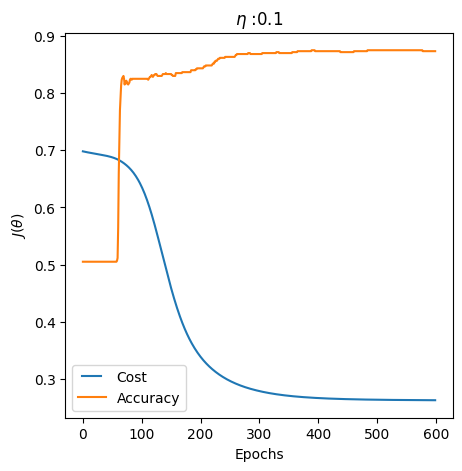

In [29]:
epochs = 600
eta = 0.1

parameters,cost_history,accuracy_history = fit(X_train,
                                   y_train,
                                  layers, epochs, eta)


# Calcul de l'accuracy sur le jeu de test
y_test_hat,_= forward_propagation(X_test, parameters, layers)
accuracy_test = accuracy(y_test_hat, y_test)
print("Accuracy : %.3f"%accuracy_test)

plot_histories (eta,epochs,cost_history,accuracy_history)

Test en modifiant le réseau pour voir si le résultat est meilleur. Attention au surapprentissage dans ce cas.

Epoch : #0 - cost : 0.692 - accuracy : 0.505
Epoch : #100 - cost : 0.676 - accuracy : 0.778
Epoch : #200 - cost : 0.432 - accuracy : 0.830
Epoch : #300 - cost : 0.261 - accuracy : 0.878
Epoch : #400 - cost : 0.228 - accuracy : 0.882
Epoch : #500 - cost : 0.174 - accuracy : 0.923
Accuracy : 0.983


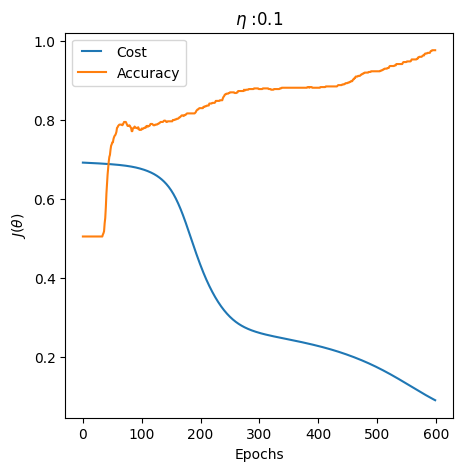

In [30]:
layers = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]


epochs = 600
eta = 0.1
parameters,cost_history,accuracy_history = fit(X_train,
                                   y_train,
                                  layers, epochs, eta)

# Calcul de l'accuracy sur le jeu de test
y_test_hat,_= forward_propagation(X_test, parameters, layers)
accuracy_test = accuracy(y_test_hat, y_test)
print("Accuracy : %.3f"%accuracy_test)

plot_histories (eta,epochs,cost_history,accuracy_history)

Essai avec Keras pour voir les résultats.

In [31]:
#Construction du modèle
model = Sequential()
model.add(Dense(25, input_dim=2,activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
epochs = 600
eta = 0.1

gd = SGD(learning_rate=eta)
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])


# Training
history = model.fit(X_train_init, y_train_init, epochs=600, verbose=0)



In [32]:
#y_test_hat = model.predict_classes()
y_test_hat=model.predict(X_test_init)
y_test_hat[y_test_hat <= 0.5] = 0.
y_test_hat[y_test_hat > 0.5] = 1.
accuracy_test = accuracy_score(y_test_init, y_test_hat)
print("Accuracy pour Keras : %.3f"%accuracy_test)

13/13 [==============================] - 0s 1ms/step
Accuracy pour Keras : 1.000


#### Implémentation avec une classe simple

Dans un premier temps, nous créons une classe simple qui reprend les fonctions précédentes et dans laquelle nous ajoutons simplement les fonctions d'activation Relu, LeakyRelu, tanh et sigmoid. Cette classe permet de faire de la classification binaire.   



Fonctions d'affichage.

In [33]:
def plot_histories (eta,epochs,cost_history,accuracy_history):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.set_ylabel(r'$J(\theta)$')
    ax.set_xlabel('Epochs')
    ax.set_title(r"$\eta$ :{}".format(eta))
    line1, = ax.plot(range(epochs),cost_history,label='Cost')
    line2, = ax.plot(range(epochs),accuracy_history,label='Accuracy')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

def plot_decision_boundary(func, X, y):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)

    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots()
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)

    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.title("Decision Boundary")

Fonctions d'activations et dérivées des fonctions : sigmoid, tanh, relu et leakyrelu.

In [34]:
# Fonctions utiles
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1.0 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - x ** 2

def relu(x):
    return np.maximum(0,x)

def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leakyrelu(x):
    return np.maximum(0.01,x)

def leakyrelu_prime(x):
    x[x<=0] = 0.01
    x[x>0] = 1
    return x


Définition de la classe MyNeuralNetwork.   

L'initialisation de la classe nécessite un réseau défini de la manière suivante :   
layers = [  
    {"input_dim": *nombre de neurones en entrée*, "output_dim": *nombre de neurones du layer*, "activation": *fonction d'activation du layer*},  
    {"input_dim": *nombre de neurones layer précédent*, "output_dim": *nombre de neurones du layer*, "activation": *fonction d'activation du layer*},  
    ...  
    {"input_dim": *nombre de neurones layer précédent*, "output_dim": 1, "activation": *fonction d'activation de l'ouput layer*}  
]  

Pour l'exemple du notebook :   
layers = [  
    {"input_dim": 2, "output_dim": 3, "activation": "relu"},  
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"}  
]  




La classe est assez similaire à l'appel des différentes fonctions. Ici dans le constructeur le réseau est construit. La principale différence est dans les fonctions forward et backward qui traitent différemment le cas des fonctions d'activations. Ici la descente de gradient se fait par mini-batch : d'où appel à la fonction *next_batch* vue dans le notebook descente de gradient qui retourne un batch de la taille de batchsize.

In [35]:
class MyNeuralNetwork(object):

    def __init__(self, layers):
        seed=30
        np.random.seed(seed)
        self.L = len(layers) #L est la couche de sortie du réseau
        self.parameters = {}
        self.derivatives = {}

        # Pour toutes les couches du réseau
        for idx, layer in enumerate(layers):

            # Par simplification on commence la numérotation du layer à 1
            # correspond aux données d'entrées (input), i.e. les variables prédictives
            layer_idx = idx + 1

            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]

            # Initialisation des valeurs de la matrice W et du vecteur b
            # pour les différentes couches
            # W est initialisé en prenant l'optimisation de He et al 2015
            self.parameters['W' + str(layer_idx)] = np.random.randn(
                layer_output_size, layer_input_size) * np.sqrt(2/layer_input_size)
            self.parameters['b' + str(layer_idx)] = np.random.randn(
                layer_output_size, 1) * 0.1

            # Sauvegarde de la fonction d'activation du réseau
            self.parameters['activation'+ str(layer_idx)]=layer["activation"]



    def forward_propagation(self, X):
        #Initialisation des variables prédictives pour la couche d'entrée
        self.parameters['A0'] = X

        #Propagation pour tous les layers
        for l in range(1, self.L + 1):

            # Calcul de Z
            self.parameters['Z' + str(l)] = np.dot(self.parameters['W' + str(l)],
                                            self.parameters['A' + str(l - 1)])+self.parameters['b' + str(l)]


            # Récupération de la fonction d'activation du layer
            activ_function_curr = self.parameters['activation' + str(l)]
            if activ_function_curr == "relu":
                activation_func = relu
            elif activ_function_curr == "sigmoid":
                activation_func = sigmoid
            elif activ_function_curr == "tanh":
                activation_func = tanh
            elif activ_function_curr == "leakyrelu":
                activation_func = leakyrelu

            # Application de la fonction d'activation à Z
            self.parameters['A' + str(l)] = activation_func(self.parameters['Z' + str(l)])

    def convert_prob_into_class(self,probs):
        probs = np.copy(probs)#pour ne pas perdre probs, i.e. y_hat
        probs[probs > 0.5] = 1
        probs[probs <= 0.5] = 0
        return probs

    def accuracy(self,y_hat, y):
        y_hat_ = self.convert_prob_into_class(y_hat)
        return (y_hat_ == y).all(axis=0).mean()


    def cost_function(self, y):
        # cross entropy
        return (-(y*np.log(self.parameters['A' + str(self.L)]+ 1e-8) + (1-y)*np.log( 1 - self.parameters['A' + str(self.L)]+ 1e-8))).mean()


    def backward_propagation(self, y):
        #Dérivées partielles de la fonction de coût pour z[L], W[L] et b[L]:
        #dzL
        self.derivatives['dZ' + str(self.L)] = self.parameters['A' + str(self.L)] - y
        #dWL
        self.derivatives['dW' + str(self.L)] = np.dot(self.derivatives['dZ' + str(self.L)],
                                                      np.transpose(self.parameters['A' + str(self.L - 1)]))
        #dbL
        #Attention pour un lot de m exemples, il faut faire la moyenne des dérivées sur les m exemples
        m = self.parameters['A' + str(self.L)].shape[1]
        self.derivatives['db' + str(self.L)]  = np.sum(self.derivatives['dZ' + str(self.L)],
                                                       axis=1, keepdims=True) / m

        #Dérivées partielles de la fonction de coût pour z[l], W[l] et b[l]
        for l in range(self.L-1, 0, -1):

            #Récupération de la dérivée de la fonction d'activation
            activ_function_backward = self.parameters['activation' + str(l)]
            if activ_function_backward == "relu":
                backward_activation_func = relu_prime
            elif activ_function_backward == "sigmoid":
                backward_activation_func = sigmoid_prime
            elif activ_function_backward == "tanh":
                backward_activation_func = tanh_prime
            elif activ_function_backward == "leakyrelu":
                backward_activation_func = leakyrelu_prime

            self.derivatives['dZ' + str(l)] = np.dot(np.transpose(self.parameters['W' + str(l + 1)]),
                self.derivatives['dZ' + str(l + 1)])*backward_activation_func(self.parameters['Z' + str(l)])

            self.derivatives['dW' + str(l)] = np.dot(self.derivatives['dZ' + str(l)],
                np.transpose(self.parameters['A' + str(l - 1)]))
            #Attention pour un lot de m exemples, il faut faire la moyenne des dérivées sur les m exemples
            m = self.parameters['A' + str(l - 1)].shape[1]
            self.derivatives['db' + str(l)]  = np.sum(self.derivatives['dZ' + str(l)],
                                                      axis=1, keepdims=True) / m

    def update_parameters(self, eta):
        # Descente de gradient
        for l in range(1, self.L+1):
            self.parameters['W' + str(l)] -= eta*self.derivatives['dW' + str(l)]
            self.parameters['b' + str(l)] -= eta*self.derivatives['db' + str(l)]

    def predict(self, x):
        self.forward_propagation(x)
        return self.parameters['A' + str(self.L)]

    def next_batch(self,X, y, batchsize):
        # pour avoir X de la forme : 2 colonnes, m lignes (examples) et également y
        # cela permet de trier les 2 tableaux avec un indices de permutation
        X=np.transpose(X)
        y=np.transpose(y)

        m=len(y)
        # permutation aléatoire de X et y pour faire des batchs avec des valeurs au hasard
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in np.arange(0, X.shape[0], batchsize):
            # creation des batchs de taille batchsize
            yield (X[i:i + batchsize], y[i:i + batchsize])



    def fit(self, X, y, epochs, eta = 0.01,batchsize=64):

        # sauvegarde historique coût et accuracy pour affichage
        cost_history = []
        accuracy_history = []
        for i in range(epochs):
            # sauvegarde des coûts et accuracy par mini-batch
            cost_batch = []
            accuracy_batch = []
            # Descente de gradient par mini-batch
            for (batchX, batchy) in self.next_batch(X, y, batchsize):
                # Extraction et traitement d'un batch à la fois

                # mise en place des données au bon format
                batchX=np.transpose(batchX)
                batchy=np.transpose(batchy.reshape((batchy.shape[0], 1)))

                self.forward_propagation(batchX)
                self.backward_propagation(batchy)
                self.update_parameters(eta)

                # sauvegarde pour affichage
                current_cost=self.cost_function(batchy)
                cost_batch.append(current_cost)
                y_hat = self.predict(batchX)
                current_accuracy = self.accuracy(y_hat, batchy)
                accuracy_batch.append(current_accuracy)


            # sauvegarde de la valeur moyenne des coûts et de l'accuracy du batch pour affichage
            current_cost=np.average(cost_batch)
            cost_history.append(current_cost)
            current_accuracy=np.average(accuracy_batch)
            accuracy_history.append(current_accuracy)

            if(i % 10 == 0):
                print("Epoch : #%s - cost : %.3f - accuracy : %.3f"%(i, float(current_cost), current_accuracy))
        return self.parameters, cost_history, accuracy_history

Utilisation de la classe sur un jeu de données.

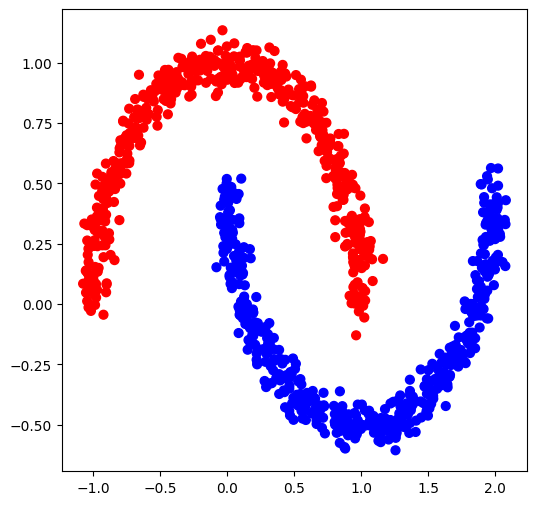

In [36]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm_bright)#cmap=plt.cm.PiYG)

Création d'un jeu de données d'apprentissage et de test.

In [37]:
#création d'un jeu d'apprentissage et de test

validation_size=0.6 #40% du jeu de données pour le test

testsize= 1-validation_size
seed=30
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               train_size=validation_size,
                                               random_state=seed,
                                               test_size=testsize)

Attention, les variables prédictives $X$ doivent être sous la forme $m$ colonnes où $m$ est le nombre d'exemples d'apprentissage et $l$ lignes où $l$ est le nombre de variables prédictives. Dans notre exemple du notebook, il y a deux variables prédictives donc il faut passer que $X$ soit de la forme $m$ colonnes et 2 lignes.

In [38]:
#transformation des données pour être au bon format
# X_train est de la forme : 2 colonnes, m lignes (examples)
# y_train est de la forme : m colonnes, 1 ligne

# La transposée de X_train est de la forme : m colonnes (exemples), 2 lignes
X_train=np.transpose(X_train)

# y_train est forcé pour être un tableau à 1 ligne contenant m colonnes
y_train=np.transpose(y_train.reshape((y_train.shape[0], 1)))

# mêmes traitements pour le jeu de test
X_test=np.transpose(X_test)
y_test=np.transpose(y_test.reshape((y_test.shape[0], 1)))





Création du réseau, entraînement du classifieur et prédiction.

In [39]:
# le réseau du notebook
layers = [
    {"input_dim": 2, "output_dim": 3, "activation": "relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"}
]
epochs = 100
eta = 0.01
batchsize=32

#Création du classifieur (mise en place des layers et initialisation des W et b)
# optimizer = bgd (descente par mini-batch) par défaut sinon optimizer="momentum"/"adam"
clf = MyNeuralNetwork(layers)

#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta,batchsize)

#Prédiction
y_pred=clf.predict(X_test)
accuracy_test = clf.accuracy(y_pred, y_test)
print("Accuracy test: %.3f"%accuracy_test)

Epoch : #0 - cost : 0.557 - accuracy : 0.534
Epoch : #10 - cost : 0.315 - accuracy : 0.875
Epoch : #20 - cost : 0.254 - accuracy : 0.883
Epoch : #30 - cost : 0.248 - accuracy : 0.883
Epoch : #40 - cost : 0.242 - accuracy : 0.891
Epoch : #50 - cost : 0.228 - accuracy : 0.901
Epoch : #60 - cost : 0.215 - accuracy : 0.909
Epoch : #70 - cost : 0.201 - accuracy : 0.906
Epoch : #80 - cost : 0.191 - accuracy : 0.915
Epoch : #90 - cost : 0.189 - accuracy : 0.925
Accuracy test: 0.945


Affichage de l'historique de la fonction de coût et de l'accuracy ainsi que de la frontière de décision.

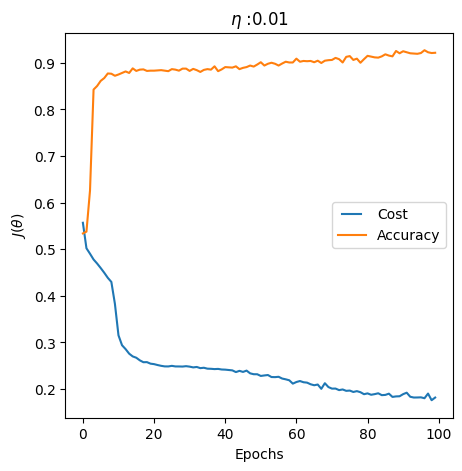

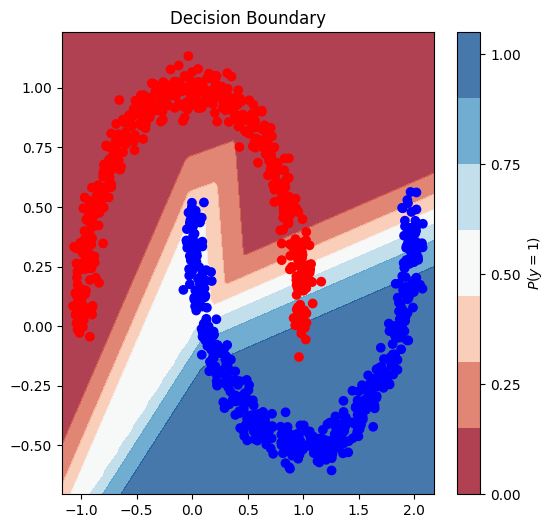

In [40]:
# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)
# Affichage de la frontière de décision
plot_decision_boundary(lambda x: clf.predict(np.transpose(x)), X, y)
#plot_decision_boundary(lambda x: clf.predict(np.transpose(x)), X, y)

En changeant la configuration du réseau. Attention au surapprentissage.

Epoch : #0 - cost : 0.476 - accuracy : 0.783
Epoch : #10 - cost : 0.219 - accuracy : 0.882
Epoch : #20 - cost : 0.201 - accuracy : 0.898
Epoch : #30 - cost : 0.179 - accuracy : 0.909
Epoch : #40 - cost : 0.180 - accuracy : 0.919
Epoch : #50 - cost : 0.175 - accuracy : 0.941
Epoch : #60 - cost : 0.140 - accuracy : 0.961
Epoch : #70 - cost : 0.124 - accuracy : 0.969
Epoch : #80 - cost : 0.108 - accuracy : 0.983
Epoch : #90 - cost : 0.088 - accuracy : 0.990
Accuracy : 0.988


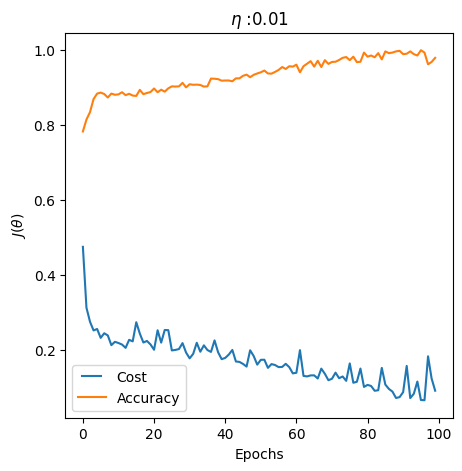

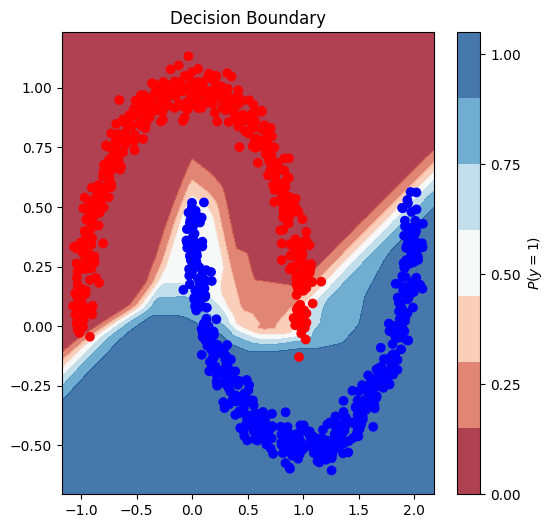

In [41]:
layers = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 3, "activation": "relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"}
]

clf = MyNeuralNetwork(layers)

#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta)

y_pred=clf.predict(X_test)
accuracy_test = clf.accuracy(y_pred, y_test)
print("Accuracy : %.3f"%accuracy_test)
# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)
# Affichage de la frontière de décision
plot_decision_boundary(lambda x: clf.predict(np.transpose(x)), X, y)


#### Classe avec optimisation (momentum, adam) pour faire de la classification multi-classes

Dans cette section, nous présentons une classe plus complète qui permet de faire de la classification multi-classes, i.e. via la fonction d'activation softmax. En outre, elle propose de pouvoir utiliser des optimisations : momentum et adam.   

La structure de la classe est assez similaire à la précédente.  
La fonction predict est changée pour pouvoir prédire la classe d'appartenance lors de multi-classes.  
La fonction update prend en compte le fait que l'optimisation peut être de type momentum ou adam.  
Le constructeur prend par défaut *optimizer="bgd"* (*batch gradient descent*) (les valeurs possibles sont *"momentum"* ou *"adam"*.
Enfin lors de l'appel de la fonction fit les paramètres beta, beta1 et epsilon doivent être spécifiées (en cas d'appel d'un optimizer. Ici il y a des valeurs par défaut : beta=0.9,beta2=0.999, epsilon=1e-8.

La construction du réseau est similaire à celui de la classe précédente :  

Pour l'exemple du notebook :   
layers = [  
    {"input_dim": 2, "output_dim": 3, "activation": "relu"},  
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"}  
]  


In [42]:
#fonctions utiles
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1.0 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - x ** 2

def relu(x):
    return np.maximum(0,x)

def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leakyrelu(x):
    return np.maximum(0.01,x)

def leakyrelu_prime(x):
    x[x<=0] = 0.01
    x[x>0] = 1
    return x

def softmax(x):
    expx = np.exp(x - np.max(x))
    return expx / expx.sum(axis=0, keepdims=True)

In [43]:
class MyNeuralNetwork(object):

    def __init__(self, layers,optimizer="bgd"):
        seed=30
        np.random.seed(seed)
        self.L = len(layers) #L est la couche de sortie du réseau
        self.parameters = {}
        self.derivatives = {}
        self.optimizer=optimizer
        if optimizer=="momentum":
            self.v={} # vitesse pour momentum
        elif optimizer == "adam":
            self.v={}
            self.s={}
            self.t=2


        # Pour toutes les couches du réseau
        for idx, layer in enumerate(layers):

            # Par simplification on commence la numérotation du layer à 1
            # correspond aux données d'entrées (input), i.e. les variables prédictives
            layer_idx = idx + 1

            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]

            # Initialisation des valeurs de la matrice W et du vecteur b
            # pour les différentes couches
            # W est initialisé en prenant l'optimisation de He et al 2015
            self.parameters['W' + str(layer_idx)] = np.random.randn(
                layer_output_size, layer_input_size) * np.sqrt(2/layer_input_size)
            self.parameters['b' + str(layer_idx)] = np.random.randn(
                layer_output_size, 1) * 0.1

            # Sauvegarde de la fonction d'activation du réseau
            self.parameters['activation'+ str(layer_idx)]=layer["activation"]
            if optimizer=="momentum":
                # Sauvegarde velocity, v, pour momentum
                self.v['dW' + str(layer_idx)] = np.zeros_like(self.parameters['W' + str(layer_idx)])
                self.v['db' + str(layer_idx)] = np.zeros_like(self.parameters['b' + str(layer_idx)])
            elif optimizer=='adam':
                self.v['dW' + str(layer_idx)] = np.zeros_like(self.parameters['W' + str(layer_idx)])
                self.v['db' + str(layer_idx)] = np.zeros_like(self.parameters['b' + str(layer_idx)])
                self.s['dW' + str(layer_idx)] = np.zeros_like(self.parameters['W' + str(layer_idx)])
                self.s['db' + str(layer_idx)] = np.zeros_like(self.parameters['b' + str(layer_idx)])


    def forward_propagation(self, X):
        #Initialisation des variables prédictives pour la couche d'entrée
        self.parameters['A0'] = X

        #Propagation pour tous les layers
        for l in range(1, self.L + 1):

            # Calcul de Z
            self.parameters['Z' + str(l)] = np.dot(self.parameters['W' + str(l)],
                                            self.parameters['A' + str(l - 1)])+self.parameters['b' + str(l)]

            # Récupération de la fonction d'activation du layer
            activ_function_curr = self.parameters['activation' + str(l)]
            if activ_function_curr == "relu":
                activation_func = relu
            elif activ_function_curr == "sigmoid":
                activation_func = sigmoid
            elif activ_function_curr == "tanh":
                activation_func = tanh
            elif activ_function_curr == "leakyrelu":
                activation_func = leakyrelu
            elif activ_function_curr == "softmax":
                activation_func = softmax

            # Application de la fonction d'activation à Z
            self.parameters['A' + str(l)] = activation_func(self.parameters['Z' + str(l)])


    def convert_prob_into_class(self,probs):
        probs = np.copy(probs)#pour ne pas perdre probs, i.e. y_hat
        probs[probs > 0.5] = 1
        probs[probs <= 0.5] = 0
        return probs


    def accuracy(self,y_hat, y):
        if self.parameters['activation' + str(self.L)]=="softmax":
            # si la fonction est softmax, les valeurs sont sur différentes dimensions
            # il faut utiliser argmax avec axis=0 pour avoir un vecteur qui indique
            # où est la valeur maximale à la fois pour y_hat et pour y
            # comme cela il suffit de comparer les deux vecteurs qui indiquent
            # dans quelle ligne se trouve le max
            y_hat_encoded=np.copy(y_hat)
            y_hat_encoded = np.argmax(y_hat_encoded, axis=0)
            y_encoded=np.copy(y)
            y_encoded=np.argmax(y_encoded, axis=0)
            return (y_hat_encoded == y_encoded).mean()
        # la dernière fonction d'activation n'est pas softmax.
        # par exemple sigmoid pour une classification binaire
        # il suffit de convertir la probabilité du résultat en classe
        y_hat_ = self.convert_prob_into_class(y_hat)
        return (y_hat_ == y).all(axis=0).mean()


    def cost_function(self, y):
        # cross entropy
        return (-(y*np.log(self.parameters['A' + str(self.L)]+1e-8) + (1-y)*np.log( 1 - self.parameters['A' + str(self.L)]+1e-8))).mean()


    def backward_propagation(self, y):
        #Dérivées partielles de la fonction de coût pour z[L], W[L] et b[L]:
        #dzL
        self.derivatives['dZ' + str(self.L)] = self.parameters['A' + str(self.L)] - y
        #dWL
        self.derivatives['dW' + str(self.L)] = np.dot(self.derivatives['dZ' + str(self.L)],
                                                      np.transpose(self.parameters['A' + str(self.L - 1)]))
        #dbL
        #Attention pour un lot de m exemples, il faut faire la moyenne des dérivées sur les m exemples
        m = self.parameters['A' + str(self.L)].shape[1]
        self.derivatives['db' + str(self.L)]  = np.sum(self.derivatives['dZ' + str(self.L)],
                                                       axis=1, keepdims=True) / m

        #Dérivées partielles de la fonction de coût pour z[l], W[l] et b[l]
        for l in range(self.L-1, 0, -1):

            #Récupération de la dérivée de la fonction d'activation
            activ_function_backward = self.parameters['activation' + str(l)]
            if activ_function_backward == "relu":
                backward_activation_func = relu_prime
            elif activ_function_backward == "sigmoid":
                backward_activation_func = sigmoid_prime
            elif activ_function_backward == "tanh":
                backward_activation_func = tanh_prime
            elif activ_function_backward == "leakyrelu":
                backward_activation_func = leakyrelu_prime

            self.derivatives['dZ' + str(l)] = np.dot(np.transpose(self.parameters['W' + str(l + 1)]),
                self.derivatives['dZ' + str(l + 1)])*backward_activation_func(self.parameters['Z' + str(l)])

            self.derivatives['dW' + str(l)] = np.dot(self.derivatives['dZ' + str(l)],
                np.transpose(self.parameters['A' + str(l - 1)]))
            #Attention pour un lot de m exemples, il faut faire la moyenne des dérivées sur les m exemples
            m = self.parameters['A' + str(l - 1)].shape[1]
            self.derivatives['db' + str(l)]  = np.sum(self.derivatives['dZ' + str(l)],
                                                      axis=1, keepdims=True) / m

    def update_parameters(self, eta,beta, beta2=0.999, epsilon=1e-8):
        # Descente de gradient
        if self.optimizer=="adam":
            v_corrected = {}            # Initialisation de la première estimation du moment
            s_corrected = {}            # Initialisation de la seconde estimation du moment

        for l in range(1, self.L+1):
            if self.optimizer=="momentum":
                # Calcul de la vitesse
                self.v['dW' + str(l)] = beta * self.v['dW' + str(l)] + (1 - beta) * self.derivatives['dW' + str(l)]
                self.v['db' + str(l)] = beta * self.v['db' + str(l)] + (1 - beta) * self.derivatives['db' + str(l)]

                # Mise à jour des paramètres
                self.parameters['W' + str(l)] -= eta*self.v['dW' + str(l)]
                self.parameters['b' + str(l)] -= eta*self.v['db' + str(l)]
            elif self.optimizer=="adam":
                # Calcul de la vitesse
                self.v['dW' + str(l)] = beta * self.v['dW' + str(l)] + (1 - beta) * self.derivatives['dW' + str(l)]
                self.v['db' + str(l)] = beta * self.v['db' + str(l)] + (1 - beta) * self.derivatives['db' + str(l)]

                # Calcul de la première estimation du moment (correction du biais)
                v_corrected["dW" + str(l)] = self.v["dW" + str(l)] / (1 - np.power(beta, self.t))
                v_corrected["db" + str(l)] = self.v["db" + str(l)] / (1 - np.power(beta, self.t))

                 # déplacement moyen des gradients au carré
                self.s["dW" + str(l)] = beta2 * self.s["dW" + str(l)] + (1 - beta2) * np.power(self.derivatives['dW' + str(l)], 2)
                self.s["db" + str(l)] = beta2 * self.s["db" + str(l)] + (1 - beta2) * np.power(self.derivatives['db' + str(l)], 2)

                # Calcul de la seconde estimation du moment (correction du biais)
                s_corrected["dW" + str(l)] = self.s["dW" + str(l)] / (1 - np.power(beta2, self.t))
                s_corrected["db" + str(l)] = self.s["db" + str(l)] / (1 - np.power(beta2, self.t))

                # Mise à jour des paramètres
                self.parameters['W' + str(l)] -= eta*v_corrected["dW" + str(l)] / np.sqrt(s_corrected["dW" + str(l)] + epsilon)
                self.parameters['b' + str(l)] -= eta*v_corrected["db" + str(l)] / np.sqrt(s_corrected["db" + str(l)] + epsilon)

            else: #descente par mini-lots
                self.parameters['W' + str(l)] -= eta*self.derivatives['dW' + str(l)]
                self.parameters['b' + str(l)] -= eta*self.derivatives['db' + str(l)]


    def predict(self, x):
        self.forward_propagation(x)
        return self.parameters['A' + str(self.L)]


    def next_batch(self,X, y, batchsize):
        # pour avoir X de la forme : 2 colonnes, m lignes (examples) et également y
        # cela permet de trier les 2 tableaux avec un indices de permutation
        X=np.transpose(X)
        y=np.transpose(y)

        m=len(y)
        # permutation aléatoire de X et y pour faire des batchs avec des valeurs au hasard
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in np.arange(0, X.shape[0], batchsize):
            # creation des batchs de taille batchsize
            yield (X[i:i + batchsize], y[i:i + batchsize])



    def fit(self, X, y, epochs, eta = 0.01,batchsize=32,beta=0.9,beta2=0.999, epsilon=1e-8):

        # sauvegarde historique coût et accuracy pour affichage
        cost_history = []
        accuracy_history = []
        for i in range(epochs):
            # sauvegarde des coûts et accuracy par mini-batch
            cost_batch = []
            accuracy_batch = []
            # Descente de gradient par mini-batch
            for (batchX, batchy) in self.next_batch(X, y, batchsize):
                # Extraction et traitement d'un batch à la fois

                # mise en place des données au bon format
                batchX=np.transpose(batchX)
                if self.parameters['activation' + str(self.L)]=="softmax":
                    # la classification n'est pas binaire, y a utilisé one-hot-encoder
                    # le batchy doit donc être transposé et le résultat doit
                    # être sous la forme d'une matrice de taille batchy.shape[1]
                    batchy=np.transpose(batchy.reshape((batchy.shape[0], batchy.shape[1])))
                else:
                    # il s'agit d'une classification binaire donc shape[1] n'existe
                    # pas
                    batchy=np.transpose(batchy.reshape((batchy.shape[0], 1)))


                self.forward_propagation(batchX)
                self.backward_propagation(batchy)
                if self.optimizer=="adam":
                    self.t=self.t+1
                self.update_parameters(eta,beta,beta2,epsilon)
                #else:
                #    self.update_parameters(eta,0)

                # sauvegarde pour affichage
                current_cost=self.cost_function(batchy)
                cost_batch.append(current_cost)
                y_hat = self.predict(batchX)
                current_accuracy = self.accuracy(y_hat, batchy)
                accuracy_batch.append(current_accuracy)


            # sauvegarde de la valeur moyenne des coûts et de l'accuracy du batch pour affichage
            current_cost=np.average(cost_batch)
            cost_history.append(current_cost)
            current_accuracy=np.average(accuracy_batch)
            accuracy_history.append(current_accuracy)

            if(i % 10 == 0):
                print("Epoch : #%s - cost : %.3f - accuracy : %.3f"%(i, float(current_cost), current_accuracy))
        return self.parameters, cost_history, accuracy_history

#### Essai classe avec optimisation sur différents jeux de données - classification binaire

Sélection du jeu de données

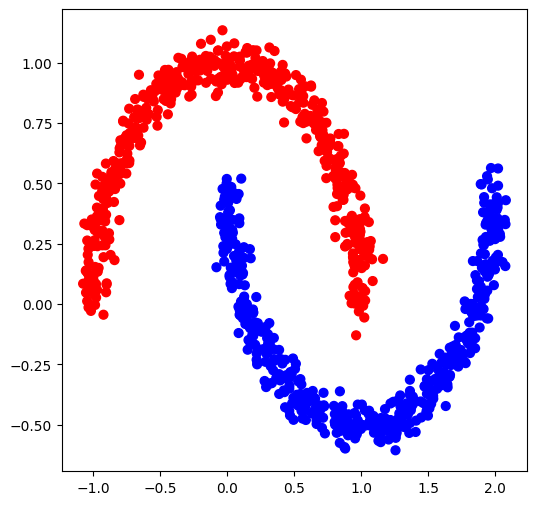

In [44]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm_bright)#cmap=plt.cm.PiYG)

Le même en utilisant l'optimisation Momentum.

Avec Momentum
Epoch : #0 - cost : 0.548 - accuracy : 0.738
Epoch : #10 - cost : 0.227 - accuracy : 0.874
Epoch : #20 - cost : 0.203 - accuracy : 0.885
Epoch : #30 - cost : 0.189 - accuracy : 0.904
Epoch : #40 - cost : 0.176 - accuracy : 0.922
Epoch : #50 - cost : 0.135 - accuracy : 0.956
Epoch : #60 - cost : 0.090 - accuracy : 0.985
Epoch : #70 - cost : 0.054 - accuracy : 0.998
Epoch : #80 - cost : 0.014 - accuracy : 1.000
Epoch : #90 - cost : 0.005 - accuracy : 1.000
Accuracy : 1.000


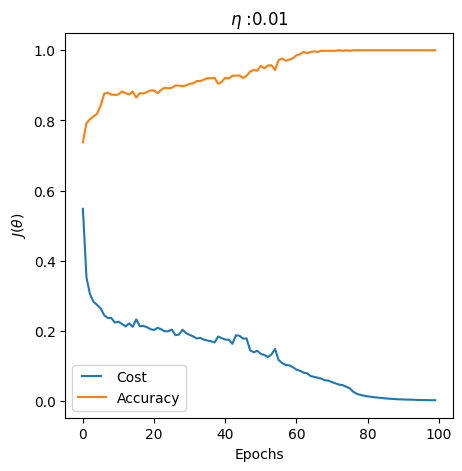

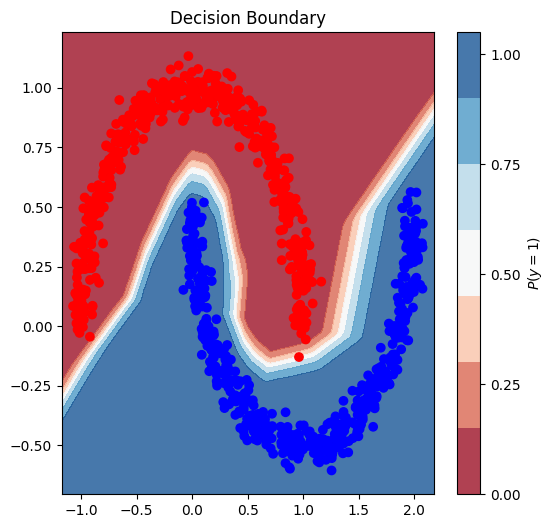

In [45]:
print ("Avec Momentum")
#Création du classifieur (mise en place des layers et initialisation des W et b)
optimizer="momentum"
clf = MyNeuralNetwork(layers, optimizer)
beta=0.9
#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta)

y_pred=clf.predict(X_test)
accuracy_test = clf.accuracy(y_pred, y_test)
print("Accuracy : %.3f"%accuracy_test)
# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)
# Affichage de la frontière de décision
plot_decision_boundary(lambda x: clf.predict(np.transpose(x)), X, y)

Le même avec adam.

Avec Adam
Epoch : #0 - cost : 0.678 - accuracy : 0.659
Epoch : #10 - cost : 0.084 - accuracy : 0.972
Epoch : #20 - cost : 0.005 - accuracy : 1.000
Epoch : #30 - cost : 0.001 - accuracy : 1.000
Epoch : #40 - cost : 0.001 - accuracy : 1.000
Epoch : #50 - cost : 0.000 - accuracy : 1.000
Epoch : #60 - cost : 0.000 - accuracy : 1.000
Epoch : #70 - cost : 0.000 - accuracy : 1.000
Epoch : #80 - cost : 0.000 - accuracy : 1.000
Epoch : #90 - cost : 0.000 - accuracy : 1.000
Accuracy test : 1.000


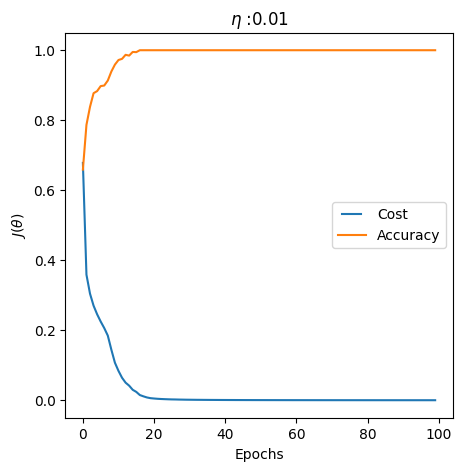

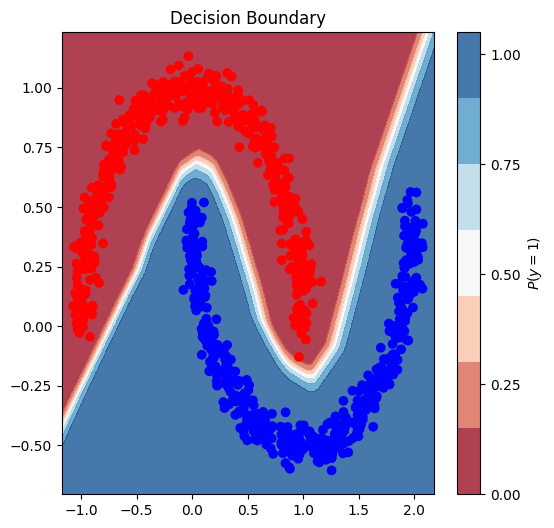

In [46]:
print ("Avec Adam")
#Création du classifieur (mise en place des layers et initialisation des W et b)
optimizer="adam"
clf = MyNeuralNetwork(layers, optimizer)
beta=0.9
beta2=0.999
epsilon=1e-8
#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta)

y_pred=clf.predict(X_test)
accuracy_test = clf.accuracy(y_pred, y_test)
print("Accuracy test : %.3f"%accuracy_test)
# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)
# Affichage de la frontière de décision
plot_decision_boundary(lambda x: clf.predict(np.transpose(x)), X, y)

Test sur un autre jeu de données.

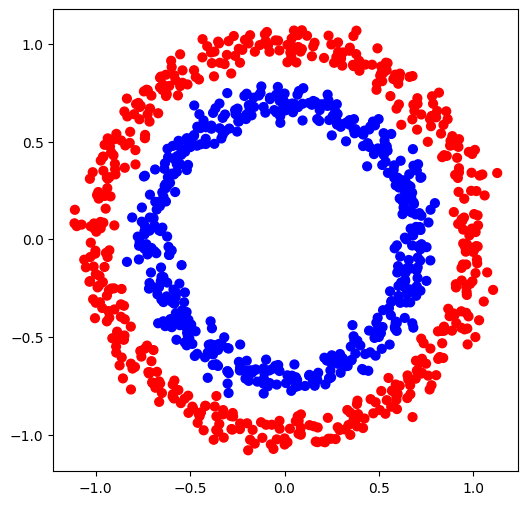

In [47]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.7, random_state=0)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm_bright)#cmap=plt.cm.PiYG)

Batch gradient descent
Epoch : #0 - cost : 0.709 - accuracy : 0.522
Epoch : #10 - cost : 0.638 - accuracy : 0.621
Epoch : #20 - cost : 0.521 - accuracy : 0.817
Epoch : #30 - cost : 0.236 - accuracy : 0.949
Epoch : #40 - cost : 0.069 - accuracy : 0.996
Epoch : #50 - cost : 0.027 - accuracy : 1.000
Epoch : #60 - cost : 0.356 - accuracy : 0.940
Epoch : #70 - cost : 0.017 - accuracy : 1.000
Epoch : #80 - cost : 0.011 - accuracy : 1.000
Epoch : #90 - cost : 0.494 - accuracy : 0.947
Epoch : #100 - cost : 0.009 - accuracy : 1.000
Epoch : #110 - cost : 0.007 - accuracy : 1.000
Epoch : #120 - cost : 0.006 - accuracy : 1.000
Epoch : #130 - cost : 0.005 - accuracy : 1.000
Epoch : #140 - cost : 0.006 - accuracy : 1.000
Epoch : #150 - cost : 0.004 - accuracy : 1.000
Epoch : #160 - cost : 0.004 - accuracy : 1.000
Epoch : #170 - cost : 0.004 - accuracy : 1.000
Epoch : #180 - cost : 0.004 - accuracy : 1.000
Epoch : #190 - cost : 0.003 - accuracy : 1.000

Batch gradient descent et momentum
Epoch : #0 -

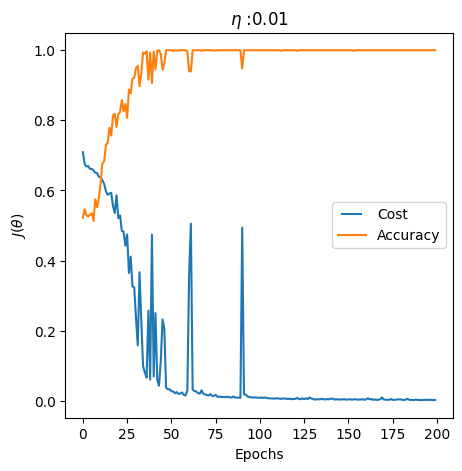

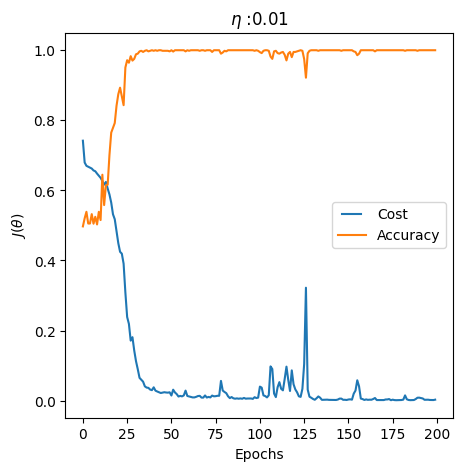

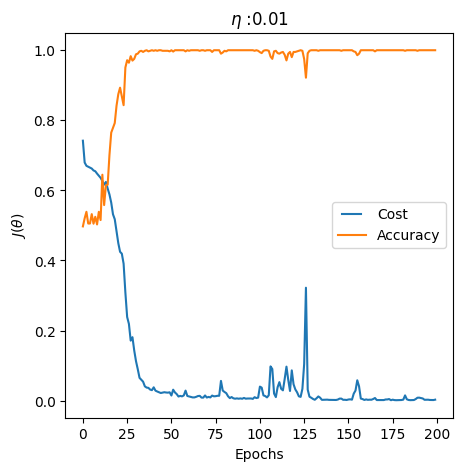

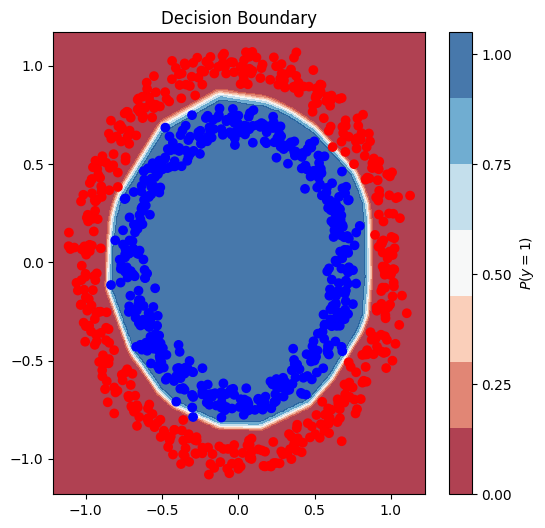

In [48]:
validation_size=0.6 #40% du jeu de données pour le test

testsize= 1-validation_size
seed=30
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               train_size=validation_size,
                                               random_state=seed,
                                               test_size=testsize)


#transformation des données pour être au bon format
# X_train est de la forme : 2 colonnes, m lignes (examples)
# y_train est de la forme : m colonnes, 1 ligne

# La transposée de X_train est de la forme : m colonnes (exemples), 2 lignes
X_train=np.transpose(X_train)

# y_train est forcé pour être un tableau à 1 ligne contenant m colonnes
y_train=np.transpose(y_train.reshape((y_train.shape[0], 1)))

# mêmes traitements pour le jeu de test
X_test=np.transpose(X_test)
y_test=np.transpose(y_test.reshape((y_test.shape[0], 1)))


# déclaration de l'architecture du réseau
layers = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 3, "activation": "relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"},
]


epochs = 200
eta = 0.01
beta=0.9
beta2=0.999
epsilon=1e-8
#Création du classifieur (mise en place des layers et initialisation des W et b)
print ("Batch gradient descent")
clf = MyNeuralNetwork(layers)
#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta)
plot_histories (eta,epochs,cost_history,accuracy_history)
print ("\nBatch gradient descent et momentum")
clf = MyNeuralNetwork(layers,optimizer="momentum")
#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta)
plot_histories (eta,epochs,cost_history,accuracy_history)
print ("\nBatch gradient descent et adam")
clf = MyNeuralNetwork(layers,optimizer="momentum")
#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta)
plot_histories (eta,epochs,cost_history,accuracy_history)

#Prédiction
y_pred= clf.predict(X_test)
accuracy_test = clf.accuracy(y_pred, y_test)
print("Accuracy test : %.3f"%accuracy_test)

# Affichage de la frontière de décision
plot_decision_boundary(lambda x: clf.predict(np.transpose(x)), X, y)

#### Essai classe avec classification multi-classes (softmax)

Dans cette section, nous illustrons l'utilisation de la fonction d'activation softmax pour faire de la classification multi-classes. Nous reprenons l'exemple d'IRIS.

In [49]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['SepalLengthCm', 'SepalWidthCm',
         'PetalLengthCm', 'PetalWidthCm',
         'Species']

df = pd.read_csv(url, names=names)

# mélange des données
df=df.sample(frac=1).reset_index(drop=True)


array = df.values #necessité de convertir le dataframe en numpy
#X matrice de variables prédictives - attention forcer le type à float
X = array[:,0:4].astype('float32')
#y vecteur de variable à prédire
y = array[:,4]


Première étape : normalisation des données

In [50]:
# normalisation de X
sc_X=StandardScaler()
X=sc_X.fit_transform(X)

Seconde étape : transformation des variables prédites à l'aide de OneHotEncoder : mettre 1 colonne par classe. Quand un exemple d'apprentissage correspond à la classe, il y a un 1 à la ligne et la colonne correspondante.

In [51]:
# Conversion de la variable à prédire via OneHotEncoder
# Dans IRIS il y a 3 classes -> création de 3 colonnes pour y
# 1 colonne correspond à 1 classe -> 1 si la ligne est du type de la classe
# 0 sinon

# Integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)



Comme précédemment création du jeu d'apprentissage et de test. Attention, il faut mettre les variables prédictives et prédites au bon format.

In [52]:
# Jeu de test/apprentissage
validation_size=0.6 #40% du jeu de données pour le test

testsize= 1-validation_size
seed=30
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               train_size=validation_size,
                                               random_state=seed,
                                               test_size=testsize)


#transformation des données pour être au bon format
# X_train est de la forme : n colonnes (variables à prédire après OneHotEncoder), m lignes (examples)
# y_train est de la forme : m colonnes, n lignes (variables à prédire après OneHotEncoder)

# La transposée de X_train est de la forme : m colonnes (exemples), n lignes (nombre de variables prédictives)
X_train=np.transpose(X_train)

# y_train est forcé pour être un tableau à 1 ligne contenant m colonnes
y_train=np.transpose(y_train.reshape((y_train.shape[0], y_train.shape[1])))

# mêmes traitements pour le jeu de test
X_test=np.transpose(X_test)
y_test=np.transpose(y_test.reshape((y_test.shape[0], y_test.shape[1])))


Création du réseau et lancement du classifieur.

Epoch : #0 - cost : 0.557 - accuracy : 0.500
Epoch : #10 - cost : 0.127 - accuracy : 0.944
Epoch : #20 - cost : 0.067 - accuracy : 0.978
Epoch : #30 - cost : 0.043 - accuracy : 0.989
Epoch : #40 - cost : 0.031 - accuracy : 1.000
Epoch : #50 - cost : 0.025 - accuracy : 1.000
Epoch : #60 - cost : 0.021 - accuracy : 1.000
Epoch : #70 - cost : 0.019 - accuracy : 1.000
Epoch : #80 - cost : 0.017 - accuracy : 1.000
Epoch : #90 - cost : 0.014 - accuracy : 1.000
Accuracy test: 0.967


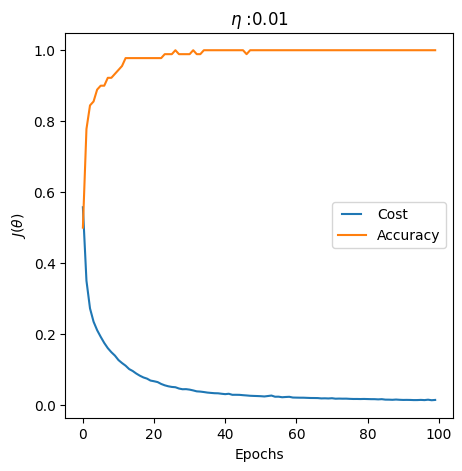

In [53]:
# déclaration de l'architecture du réseau
layers = [
    {"input_dim": 4, "output_dim": 10, "activation": "leakyrelu"},
    {"input_dim": 10, "output_dim": 3, "activation": "softmax"},
]


#Création du classifieur (mise en place des layers et initialisation des W et b)
# optimizer = bgd (descente par mini-batch) par défaut sinon optimizer="momentum"/"adam"
clf = MyNeuralNetwork(layers,optimizer="adam")


epochs = 100
eta = 0.01
batchsize=10
beta=0.9
#Entraînement du classifieur
parameters,cost_history,accuracy_history=clf.fit(X_train, y_train, epochs,eta,batchsize,beta)

#Prédiction
y_pred= clf.predict(X_test)
accuracy_test = clf.accuracy(y_pred, y_test)
print("Accuracy test: %.3f"%accuracy_test)

#Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)
